<a href="https://colab.research.google.com/github/Gusle01/ai_2025/blob/main/model2_pich_data_group.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 📦 필요한 라이브러리 설치 및 불러오기
모델 학습 및 데이터 분석에 필요한 라이브러리들을 설치하고 불러옵니다.

In [1]:
# ------------------------------------------
# 1. 환경 설정 및 구종 그룹 정의
# ------------------------------------------
# 라이브러리 설치 (최초 1회만 실행)
!pip install pybaseball autogluon.tabular scikit-learn xgboost matplotlib seaborn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pybaseball import statcast
from datetime import date, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from autogluon.tabular import TabularPredictor

# 한글 폰트 설정 (Colab용)
plt.rc('font', family='DejaVu Sans')

# 🎯 핵심: 개별 구종을 4개 그룹으로 통합
pitch_type_group_map = {
    # Fastball 계열
    'FF': 'Fastball', 'FA': 'Fastbㄴall', 'FC': 'Fastball',
    'SI': 'Fastball', 'FT': 'Fastball',

    # FS는 Offspeed가 더 정확함
    'FS': 'Offspeed',

    # Breaking 볼
    'SL': 'Breaking', 'CU': 'Breaking', 'KC': 'Breaking', 'ST': 'Breaking',

    # Offspeed
    'CH': 'Offspeed', 'EP': 'Offspeed', 'FO': 'Offspeed', 'FS': 'Offspeed',

    # 나머지
    'KN': 'Other'
}

print("✅ 환경 설정 및 그룹 매핑 완료")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.3/487.3 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.0/71.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.7/432.7 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.4 MB/s eta 0:00:00
✅ 환경 설정 및 그룹 매핑 완료


### ⚾ 시즌 연도 입력
분석할 시즌 연도를 사용자로부터 입력받습니다.

In [2]:
try:
    selected_year = int(input("⚾ 분석할 시즌 연도를 입력하세요 (예: 2024): ").strip())
except ValueError:
    print("❌ 숫자를 입력해야 합니다.")
    raise SystemExit

⚾ 분석할 시즌 연도를 입력하세요 (예: 2024): 2025


### 📅 Statcast 데이터 수집
`pybaseball` 라이브러리를 사용하여 입력된 연도의 Statcast 데이터를 월별로 수집합니다. 데이터 수집에는 다소 시간이 걸릴 수 있습니다.

In [3]:
import warnings

dfs = []
print(f"\n📅 {selected_year} 시즌 데이터 수집 중...")

# pybaseball에서 발생하는 FutureWarning를 무시합니다.
warnings.filterwarnings('ignore', category=FutureWarning, module='pybaseball')

for month in range(1, 13):
    start_date = date(selected_year, month, 1)
    end_date = date(selected_year, month + 1, 1) - timedelta(days=1) if month != 12 else date(selected_year, 12, 31)
    s, e = start_date.strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d")

    try:
        df_temp = statcast(start_dt=s, end_dt=e)
        if not df_temp.empty:
            dfs.append(df_temp)
            print(f"✔ {s} ~ {e} ({len(df_temp)} rows)")
        else:
            print(f"- {s} ~ {e} 데이터 없음")
    except Exception as ex:
        print(f"❌ {s}~{e} 오류: {ex}")

# 경고 필터를 기본값으로 재설정 (선택 사항)
warnings.filterwarnings('default', category=FutureWarning, module='pybaseball')

if not dfs:
    print("❌ 시즌 데이터가 없습니다. 종료합니다.")
    raise SystemExit

data = pd.concat(dfs, ignore_index=True)
print(f"\n✅ 총 데이터 수: {len(data)}")


📅 2025 시즌 데이터 수집 중...
This is a large query, it may take a moment to complete
Skipping offseason dates


0it [00:00, ?it/s]

- 2025-01-01 ~ 2025-01-31 데이터 없음
This is a large query, it may take a moment to complete


Skipping offseason dates


0it [00:00, ?it/s]

- 2025-02-01 ~ 2025-02-28 데이터 없음
This is a large query, it may take a moment to complete


Skipping offseason dates


100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


✔ 2025-03-01 ~ 2025-03-31 (63808 rows)
This is a large query, it may take a moment to complete


100%|██████████| 30/30 [00:23<00:00,  1.27it/s]


✔ 2025-04-01 ~ 2025-04-30 (114767 rows)
This is a large query, it may take a moment to complete


100%|██████████| 31/31 [00:28<00:00,  1.10it/s]


✔ 2025-05-01 ~ 2025-05-31 (120218 rows)
This is a large query, it may take a moment to complete


100%|██████████| 30/30 [00:23<00:00,  1.27it/s]


✔ 2025-06-01 ~ 2025-06-30 (115816 rows)
This is a large query, it may take a moment to complete


100%|██████████| 31/31 [00:21<00:00,  1.43it/s]


✔ 2025-07-01 ~ 2025-07-31 (107305 rows)
This is a large query, it may take a moment to complete


100%|██████████| 31/31 [00:28<00:00,  1.09it/s]


✔ 2025-08-01 ~ 2025-08-31 (124298 rows)
This is a large query, it may take a moment to complete


100%|██████████| 30/30 [00:30<00:00,  1.02s/it]


✔ 2025-09-01 ~ 2025-09-30 (111477 rows)
This is a large query, it may take a moment to complete


100%|██████████| 31/31 [00:02<00:00, 11.10it/s]


✔ 2025-10-01 ~ 2025-10-31 (12739 rows)
This is a large query, it may take a moment to complete
Skipping offseason dates


100%|██████████| 15/15 [00:00<00:00, 21.49it/s]

✔ 2025-11-01 ~ 2025-11-30 (367 rows)
This is a large query, it may take a moment to complete


Skipping offseason dates


0it [00:00, ?it/s]


- 2025-12-01 ~ 2025-12-31 데이터 없음

✅ 총 데이터 수: 770795


### 🎯 투수 목록 출력 및 선택
수집된 데이터에 포함된 투수 목록을 출력하고, 사용자로부터 분석할 투수를 선택받습니다. 이름 또는 ID로 검색할 수 있습니다.

In [4]:
pitchers = data[["pitcher", "player_name"]].drop_duplicates().reset_index(drop=True)
print("\n🎯 현재 시즌에 등장한 투수 목록:")
print("────────────────────────────────────────────")
for i, row in pitchers.iterrows():
    print(f"{i+1:3d}. {row['player_name']:<25} (ID: {row['pitcher']})")
print("────────────────────────────────────────────")
print(f"총 투수 수: {len(pitchers)}명\n")

user_input = input("🔍 투수 이름 또는 ID를 입력하세요 (예: Yamamoto 또는 808967): ").strip()

if user_input.isdigit():
    pitcher_id = int(user_input)
    row = pitchers[pitchers["pitcher"] == pitcher_id]
    if row.empty:
        print("❌ 해당 ID의 투수를 찾을 수 없습니다.")
        raise SystemExit
    pitcher_name = row["player_name"].values[0]
else:
    matched = pitchers[pitchers["player_name"].str.contains(user_input, case=False, na=False)]
    if matched.empty:
        print("❌ 해당 이름의 투수를 찾을 수 없습니다.")
        raise SystemExit
    print("\n🔎 검색 결과:")
    for _, r in matched.iterrows():
        print(f"- {r['player_name']} (ID: {r['pitcher']})")
    try:
        pitcher_id = int(input("\n🎯 위 목록 중 분석할 투수의 ID를 입력하세요: ").strip())
        pitcher_name = matched[matched["pitcher"] == pitcher_id]["player_name"].values[0]
    except Exception:
        print("❌ 잘못된 입력입니다.")
        raise SystemExit

print(f"\n✅ 선택된 투수: {pitcher_name} (ID: {pitcher_id})")


🎯 현재 시즌에 등장한 투수 목록:
────────────────────────────────────────────
  1. Bautista, Félix           (ID: 642585)
  2. Criswell, Cooper          (ID: 681867)
  3. Slaten, Justin            (ID: 686580)
  4. Cano, Yennier             (ID: 666974)
  5. Weissert, Greg            (ID: 669711)
  6. Akin, Keegan              (ID: 669211)
  7. Whitlock, Garrett         (ID: 676477)
  8. Domínguez, Seranthony     (ID: 622554)
  9. Bowman, Matt              (ID: 621199)
 10. Povich, Cade              (ID: 700249)
 11. Newcomb, Sean             (ID: 656794)
 12. Suter, Brent              (ID: 608718)
 13. Duran, Ezequiel           (ID: 677649)
 14. Moll, Sam                 (ID: 594580)
 15. Garabito, Gerson          (ID: 642520)
 16. Singer, Brady             (ID: 663903)
 17. Church, Marc              (ID: 687847)
 18. Rocker, Kumar             (ID: 677958)
 19. Young, Danny              (ID: 664849)
 20. Arias, Luarbert           (ID: 678215)
 21. Brazobán, Huascar         (ID: 623211)
 22. Peter

### 🧹 데이터 전처리
선택된 투수의 데이터만 필터링하고, 구종 예측에 필요한 상황 기반 피처(볼카운트, 주자 상황 등 투구 전에 알 수 있는 정보)를 추출하여 전처리합니다. 희귀 구종은 분석에서 제외됩니다.

In [5]:
# ------------------------------------------
# 4. 데이터 전처리 (구종 -> 그룹 변환)
# ------------------------------------------
df = data[(data["pitcher"] == pitcher_id) & (data["pitch_type"].notna())].copy()

# 피처 선택 (투구 전 정보)
feature_cols = [
    "balls", "strikes", "outs_when_up", "inning",
    "home_score", "away_score", "on_1b", "on_2b", "on_3b",
    "stand", "p_throws"
]

# 전처리
df["stand"] = df["stand"].map({"L": 0, "R": 1}) # 좌타:0, 우타:1
df["p_throws"] = df["p_throws"].map({"L": 0, "R": 1})
for b in ["on_1b", "on_2b", "on_3b"]:
    df[b] = df[b].notna().astype(int)

df = df[["pitch_type"] + feature_cols].dropna()

# 🎯 구종 그룹 매핑 적용
df["pitch_group"] = df["pitch_type"].map(pitch_type_group_map).fillna("Other")

# 데이터가 너무 적은 그룹 제거 (20개 미만)
group_counts = df["pitch_group"].value_counts()
valid_groups = group_counts[group_counts >= 20].index
df = df[df["pitch_group"].isin(valid_groups)].reset_index(drop=True)

print(f"🎯 분석 대상 투구 수: {len(df)}")
print(f"🎯 구종 그룹 분포:\n{df['pitch_group'].value_counts()}")

# 학습 데이터셋 분할
X = df[feature_cols].copy()
y = df["pitch_group"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

🎯 분석 대상 투구 수: 3315
🎯 구종 그룹 분포:
pitch_group
Fastball    1752
Offspeed     858
Breaking     705
Name: count, dtype: int64


### 🚀 XGBoost 모델 학습
상황 기반 피처를 사용하여 XGBoost 분류 모델을 학습합니다.

In [6]:
print("🚀 XGBoost (Group) 학습 중...")
from sklearn.preprocessing import LabelEncoder

# LabelEncoder를 사용하여 문자열 레이블을 숫자로 변환
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# 원래의 문자열 레이블과 인코딩된 숫자 레이블 간의 매핑 저장 (나중에 디코딩을 위해)
pitch_labels = list(le.classes_)

xgb_model = XGBClassifier(
    n_estimators=300, max_depth=8, learning_rate=0.05,
    eval_metric="mlogloss", random_state=42
)
xgb_model.fit(X_train, y_train_encoded)


🚀 XGBoost (Group) 학습 중...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

### 🤖 AutoGluon Tabular 모델 학습
AutoGluon Tabular를 사용하여 두 번째 분류 모델을 학습합니다. AutoGluon은 다양한 모델을 자동으로 탐색하고 최적화하여 높은 성능을 제공합니다.

In [7]:
print("\n🤖 AutoGluon Tabular (Group) 학습 중...")
train_ag = X_train.copy()
train_ag["pitch_group"] = y_train.values

# float32 변환 (호환성 확보)
for c in feature_cols:
    train_ag[c] = pd.to_numeric(train_ag[c], errors="coerce").astype(np.float32)

predictor = TabularPredictor(
    label="pitch_group", problem_type="multiclass",
    eval_metric="log_loss", path="AutogluonModels/pitch_group"
).fit(train_ag, presets="medium_quality_faster_train", verbosity=0)

print("✅ 모델 학습 완료")

Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.



🤖 AutoGluon Tabular (Group) 학습 중...


		`import catboost` failed. A quick tip is to install via `pip install autogluon.tabular[catboost]==1.4.0`.


✅ 모델 학습 완료


### 🤝 모델 앙상블 및 성능 평가
XGBoost와 AutoGluon 두 모델의 예측 확률을 결합하여 최종 앙상블 예측을 수행하고, 각 모델과 앙상블 모델의 분류 리포트를 출력하여 성능을 비교합니다.

In [8]:
# ------------------------------------------
# 6. 앙상블 및 성능 평가 (수정됨)
# ------------------------------------------

# 1️⃣ [XGBoost] 단일 모델 예측 및 리포트
# predict_proba로 확률을 구한 뒤, 가장 높은 확률의 클래스 이름(Label)을 가져옵니다.
proba_xgb_raw = xgb_model.predict_proba(X_test)
# xgb_model.classes_는 인코딩된 숫자 레이블 (0, 1)이므로, 실제 문자열 레이블로 변환합니다.
xgb_pred_idx = np.argmax(proba_xgb_raw, axis=1)
xgb_pred_labels = le.inverse_transform(xgb_pred_idx) # 숫자 예측을 문자열 레이블로 변환

print("\n============================")
print("📊 XGBoost 단일 모델 리포트")
print("============================")
print(classification_report(y_test, xgb_pred_labels, zero_division=0))

# 2️⃣ [AutoGluon] 단일 모델 예측 및 리포트
# AutoGluon은 .predict()가 바로 라벨을 반환합니다.
ag_pred_labels = predictor.predict(X_test.astype(np.float32))
ag_classes = list(predictor.class_labels)

print("\n===============================")
print("📊 AutoGluon Tabular 리포트")
print("===============================")
print(classification_report(y_test, ag_pred_labels, zero_division=0))

# 3️⃣ [Ensemble] 가중 평균 예측 및 리포트
# common_labels는 XGBoost의 문자열 레이블(pitch_labels)과 AutoGluon의 레이블을 사용합니다.
common_labels = [c for c in ag_classes if c in pitch_labels]

# 데이터프레임 변환 (공통 라벨 순서 정렬)
p_xgb_df = pd.DataFrame(proba_xgb_raw, columns=pitch_labels)[common_labels] # columns를 pitch_labels로 수정
proba_ag = predictor.predict_proba(X_test.astype(np.float32))
p_ag_df = proba_ag[common_labels]

# 가중치 적용 (XGBoost 60%, AutoGluon 40%)
w_xgb, w_ag = 0.6, 0.4
proba_ens = w_xgb * p_xgb_df.values + w_ag * p_ag_df.values

# 최종 앙상블 예측 라벨 도출
idx_max = np.argmax(proba_ens, axis=1)
ens_pred_labels = np.array(common_labels)[idx_max]

print("\n====================================")
print("📊 XGBoost + AutoGluon 앙상블 리포트")
print("====================================")
print(classification_report(y_test, ens_pred_labels, zero_division=0))



📊 XGBoost 단일 모델 리포트
              precision    recall  f1-score   support

    Breaking       0.17      0.09      0.11       141
    Fastball       0.58      0.72      0.64       350
    Offspeed       0.42      0.40      0.41       172

    accuracy                           0.50       663
   macro avg       0.39      0.40      0.39       663
weighted avg       0.45      0.50      0.47       663


📊 AutoGluon Tabular 리포트
              precision    recall  f1-score   support

    Breaking       0.27      0.02      0.04       141
    Fastball       0.58      0.86      0.70       350
    Offspeed       0.46      0.36      0.41       172

    accuracy                           0.55       663
   macro avg       0.44      0.41      0.38       663
weighted avg       0.49      0.55      0.48       663


📊 XGBoost + AutoGluon 앙상블 리포트
              precision    recall  f1-score   support

    Breaking       0.19      0.06      0.10       141
    Fastball       0.58      0.78      0.67       35

### 📉 앙상블 혼동 행렬 시각화
앙상블 모델의 예측 결과를 혼동 행렬(Confusion Matrix)로 시각화하여 어떤 구종을 혼동하는지 한눈에 파악합니다.

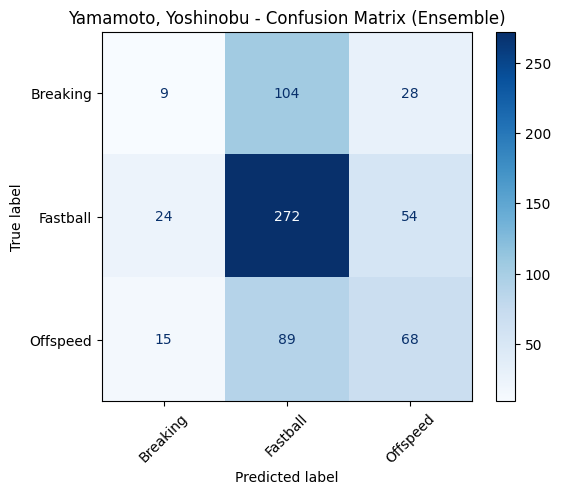

In [9]:
cm = confusion_matrix(y_test, ens_pred_labels, labels=common_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=common_labels)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title(f"{pitcher_name} - Confusion Matrix (Ensemble)")
plt.show()

### 🎯 모든 볼카운트별 모델 정확도 비교
모든 볼카운트 상황(예: 2-0, 1-2, 3-2 등)에서 각 모델과 앙상블 모델의 정확도를 비교합니다.

In [10]:
print("\n==============================")
print("🎯 모든 볼카운트별 모델 정확도 비교")
print("==============================")

# 0~3 balls × 0~2 strikes 모든 조합
all_counts = [(b, s) for b in range(4) for s in range(3)]

results = []

# 예측값 Series (기존 코드와 동일)
xgb_series = pd.Series(xgb_pred_labels, index=X_test.index)
ag_series  = pd.Series(ag_pred_labels,   index=X_test.index)
ens_series = pd.Series(ens_pred_labels,  index=X_test.index)   # ← final_pred_labels 대신 ensemble

# y_test 문자열 버전
y_test_series = pd.Series(y_test, index=X_test.index)

for balls, strikes in all_counts:

    idx = X_test[(X_test["balls"] == balls) & (X_test["strikes"] == strikes)].index

    if len(idx) == 0:
        results.append({
            "count": f"{balls}-{strikes}",
            "n_samples": 0,
            "acc_xgb": None,
            "acc_ag": None,
            "acc_ensemble": None,
        })
        continue

    y_true = y_test_series.loc[idx]
    ypx = xgb_series.loc[idx]
    ypa = ag_series.loc[idx]
    ype = ens_series.loc[idx]

    results.append({
        "count": f"{balls}-{strikes}",
        "n_samples": len(idx),
        "acc_xgb": (y_true == ypx).mean(),
        "acc_ag": (y_true == ypa).mean(),
        "acc_ensemble": (y_true == ype).mean(),
    })

# DataFrame 변환
acc_df = pd.DataFrame(results).set_index("count")

# 정렬
acc_df = acc_df.sort_index()

# 출력
print("\n📊 모든 볼카운트별 정확도 비교")
print(acc_df.to_string(formatters={
    "n_samples": lambda x: f"{x:d}",
    "acc_xgb": lambda x: f"{x:.3f}" if x is not None else "N/A",
    "acc_ag": lambda x: f"{x:.3f}" if x is not None else "N/A",
    "acc_ensemble": lambda x: f"{x:.3f}" if x is not None else "N/A",
}))


🎯 모든 볼카운트별 모델 정확도 비교

📊 모든 볼카운트별 정확도 비교
      n_samples acc_xgb acc_ag acc_ensemble
count                                      
0-0         169   0.550  0.568        0.568
0-1          89   0.461  0.472        0.483
0-2          39   0.436  0.590        0.487
1-0          71   0.521  0.549        0.549
1-1          65   0.415  0.523        0.446
1-2          57   0.351  0.404        0.368
2-0          20   0.600  0.750        0.700
2-1          40   0.725  0.775        0.775
2-2          55   0.309  0.364        0.309
3-0           5   1.000  1.000        1.000
3-1          21   0.762  0.857        0.810
3-2          32   0.531  0.656        0.562


### 📊 볼카운트별 실제 vs 예측 구종 분포 Heatmap
실제 구종 분포와 XGBoost, AutoGluon, 앙상블 모델의 예측 구종 분포를 볼카운트별 히트맵으로 시각화하여 모델의 경향성을 파악합니다.


📊 볼카운트별 실제/예측 비교 Heatmap 생성 중...



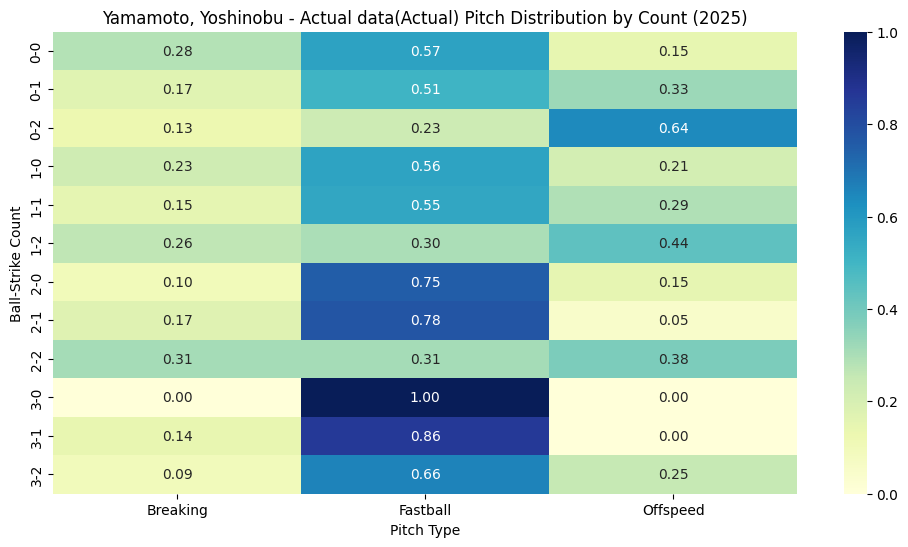

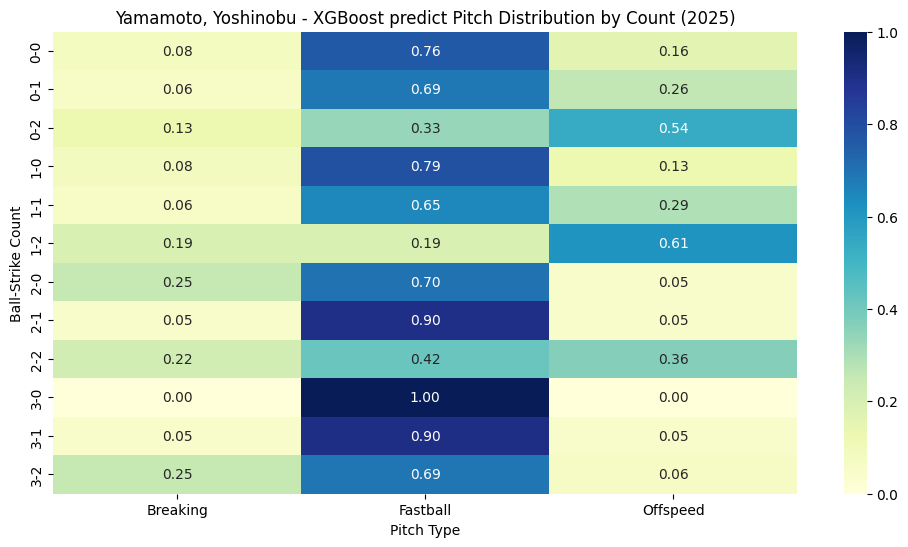

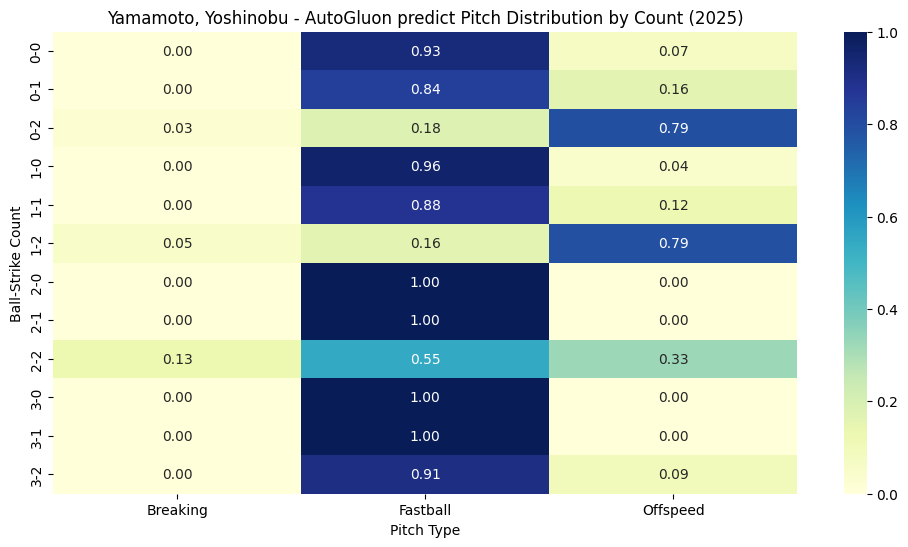

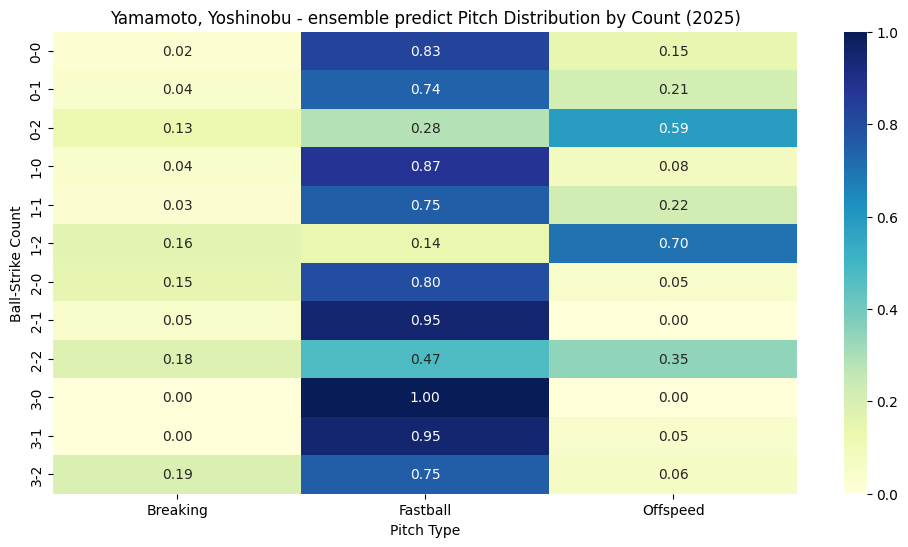

In [11]:
print("\n📊 볼카운트별 실제/예측 비교 Heatmap 생성 중...\n")

# y_test, xgb_pred_labels, ag_pred_labels, ens_pred_labels를 Series로 변환 (X_test와 인덱스 일치)
y_test_series = pd.Series(y_test, index=X_test.index)
xgb_series = pd.Series(xgb_pred_labels, index=X_test.index)
ag_series = pd.Series(ag_pred_labels, index=X_test.index)
ens_series = pd.Series(ens_pred_labels, index=X_test.index)

heatmap_rows = []
all_counts = [(b, s) for b in range(4) for s in range(3)]

for balls, strikes in all_counts:
    count_label = f"{balls}-{strikes}"
    true_idx = X_test[(X_test["balls"] == balls) & (X_test["strikes"] == strikes)].index
    true_count = y_test_series.loc[true_idx] if len(true_idx) > 0 else pd.Series([], dtype=str)

    pred_xgb = xgb_series.loc[true_idx] if len(true_idx) > 0 else pd.Series([], dtype=str)
    pred_ag  = ag_series.loc[true_idx]  if len(true_idx) > 0 else pd.Series([], dtype=str)
    pred_ens = ens_series.loc[true_idx] if len(true_idx) > 0 else pd.Series([], dtype=str)

    def get_ratio(series):
        total = len(series)
        if total == 0:
            return {pitch: 0.0 for pitch in common_labels}
        cnt = series.value_counts(normalize=True)
        return {pitch: cnt.get(pitch, 0.0) for pitch in common_labels}

    heatmap_rows.append({
        "count": count_label,
        **{f"true_{p}": r for p, r in get_ratio(true_count).items()},
        **{f"xgb_{p}": r for p, r in get_ratio(pred_xgb).items()},
        **{f"ag_{p}": r for p, r in get_ratio(pred_ag).items()},
        **{f"ens_{p}": r for p, r in get_ratio(pred_ens).items()},
    })

heatmap_df = pd.DataFrame(heatmap_rows)

sections = {
    "Actual data(Actual)": [col for col in heatmap_df.columns if col.startswith("true_")],
    "XGBoost predict":       [col for col in heatmap_df.columns if col.startswith("xgb_")],
    "AutoGluon predict":    [col for col in heatmap_df.columns if col.startswith("ag_")],
    "ensemble predict":        [col for col in heatmap_df.columns if col.startswith("ens_")],
}

for title, cols in sections.items():
    sub_df = heatmap_df.set_index("count")[cols]
    sub_df.columns = [c.split("_", 1)[1] for c in cols]

    plt.figure(figsize=(12, 6))
    sns.heatmap(sub_df, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title(f"{pitcher_name} - {title} Pitch Distribution by Count ({selected_year})")
    plt.xlabel("Pitch Type")
    plt.ylabel("Ball-Strike Count")
    plt.show()

In [12]:
# =========================================================
# 🔥 전체 df 기반 예측 — 주자 상황 × 볼카운트 × 구종 Heatmap
# =========================================================

print("\n🚀 전체 df 기반 예측 Heatmap 생성 시작...")

# ---------------------------------------------------------
# [1] 전체 df 기반 입력 데이터 생성
# ---------------------------------------------------------
df_pred = df.copy()

df_pred_X = df_pred[feature_cols].copy()

df_pred_X["stand"]   = df_pred_X["stand"].astype(int)
df_pred_X["p_throws"] = df_pred_X["p_throws"].astype(int)
df_pred_X["balls"]   = df_pred_X["balls"].astype(int)
df_pred_X["strikes"] = df_pred_X["strikes"].astype(int)

df_pred_X["count"] = df_pred_X["balls"].astype(str) + "-" + df_pred_X["strikes"].astype(str)

# 컬럼 체크
missing_cols = set(feature_cols) - set(df_pred_X.columns)
if missing_cols:
    raise ValueError(f"❌ 예측에 필요한 컬럼 누락됨: {missing_cols}")

# ---------------------------------------------------------
# [2] 전체 df에 대해 예측 수행
# ---------------------------------------------------------
print("📌 전체 df 예측 중...")

proba_xgb_full_raw = xgb_model.predict_proba(df_pred_X[feature_cols])
proba_xgb_full = pd.DataFrame(proba_xgb_full_raw, columns=pitch_labels, index=df_pred_X.index)

proba_ag_full = predictor.predict_proba(df_pred_X[feature_cols])

common_labels = [p for p in proba_ag_full.columns if p in proba_xgb_full.columns]

proba_xgb_aligned = proba_xgb_full[common_labels].values
proba_ag_aligned  = proba_ag_full[common_labels].values

w_xgb, w_ag = 0.6, 0.4
proba_ensemble_full = w_xgb * proba_xgb_aligned + w_ag * proba_ag_aligned

# ---------------------------------------------------------
# [3] 주자 상태 생성
# ---------------------------------------------------------
def base_state_pred(row):
    return f"{'1' if row['on_1b'] else '-'}" + \
           f"{'2' if row['on_2b'] else '-'}" + \
           f"{'3' if row['on_3b'] else '-'}"

df_pred_X["base_state"] = df_pred_X.apply(base_state_pred, axis=1)

base_state_label = {
    "---": "Bases Empty",
    "1--": "Runner on 1st",
    "-2-": "Runner on 2nd",
    "--3": "Runner on 3rd",
    "12-": "Runners 1st & 2nd",
    "1-3": "Runners 1st & 3rd",
    "-23": "Runners 2nd & 3rd",
    "123": "Bases Loaded"
}

df_pred_X["base_state_label"] = df_pred_X["base_state"].map(base_state_label)
df_pred_X["base_state_label"] = df_pred_X["base_state_label"].fillna("Unknown")

# ---------------------------------------------------------
# [4] 확률 병합
# ---------------------------------------------------------
df_pred_X_full = df_pred_X.copy()

for i, label in enumerate(common_labels):
    df_pred_X_full[f"xgb_{label}"] = proba_xgb_aligned[:, i]
    df_pred_X_full[f"ag_{label}"]  = proba_ag_aligned[:, i]
    df_pred_X_full[f"ens_{label}"] = proba_ensemble_full[:, i]

# ---------------------------------------------------------
# [5] Heatmap 생성
# ---------------------------------------------------------
model_sections = {
    "XGBoost Predicted Prob":   [c for c in df_pred_X_full.columns if c.startswith("xgb_")],
    "AutoGluon Predicted Prob": [c for c in df_pred_X_full.columns if c.startswith("ag_")],
    "Ensemble Predicted Prob":  [c for c in df_pred_X_full.columns if c.startswith("ens_")],
}

count_order = [f"{b}-{s}" for b in range(4) for s in range(3)]

print("\n🔮 전체 df 기반 Heatmap 생성 중...")

for model_name, cols in model_sections.items():

    print(f"\n====================================")
    print(f"📌 {model_name}")
    print("====================================")

    for bs in df_pred_X_full["base_state_label"].unique():

        sub = df_pred_X_full[df_pred_X_full["base_state_label"] == bs]

        if sub.empty:
            continue

        pivot = sub.pivot_table(values=cols, index="count", aggfunc="mean")
        pivot = pivot.reindex(count_order)

        if pivot.empty:
            continue

        pivot.columns = [c.split("_", 1)[1] for c in cols]

        plt.figure(figsize=(12, 6))
        sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".2f")
        plt.title(f"{pitcher_name} - {model_name} by Count ({bs})")
        plt.xlabel("Pitch Type (Predicted)")
        plt.ylabel("Ball-Strike Count")
        plt.show()

print("\n🎉 전체 df 기반 예측 Heatmap 생성 완료!")


📦 예측용 DataFrame(pred_df) 전체 카운트 조합으로 생성 중...
✅ pred_df 생성 완료: ['0-0' '0-1' '0-2' '1-0' '1-1' '1-2' '2-0' '2-1' '2-2' '3-0' '3-1' '3-2']


### ⚾️ 좌타 / 우타 별 볼카운트 × 구종 Heatmap (실제 데이터)
타자의 좌우 스탠스에 따른 실제 구종 분포를 볼카운트별로 히트맵을 통해 시각화합니다. 투수가 좌타자와 우타자를 상대할 때 어떤 구종을 선호하는지 파악할 수 있습니다.


📊 좌타 / 우타 별 볼카운트 × 구종 그룹 Heatmap 생성 중...


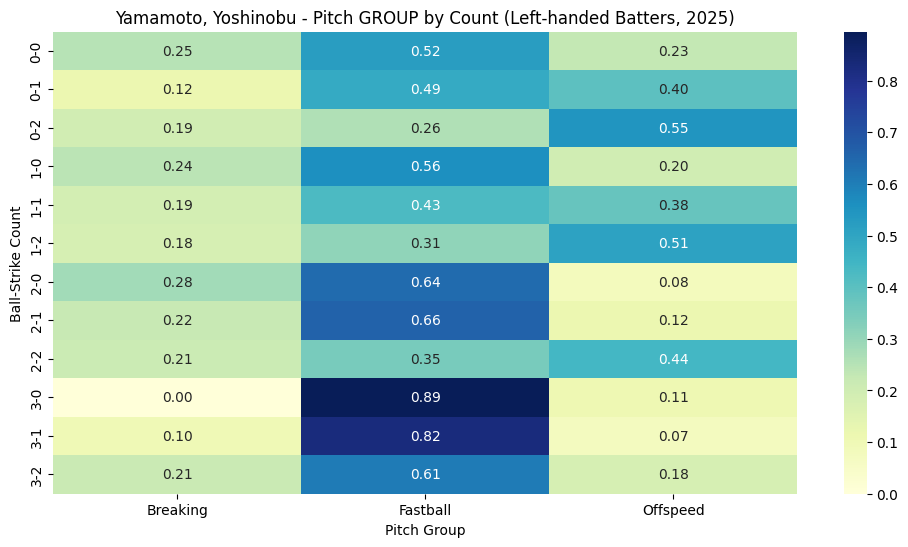

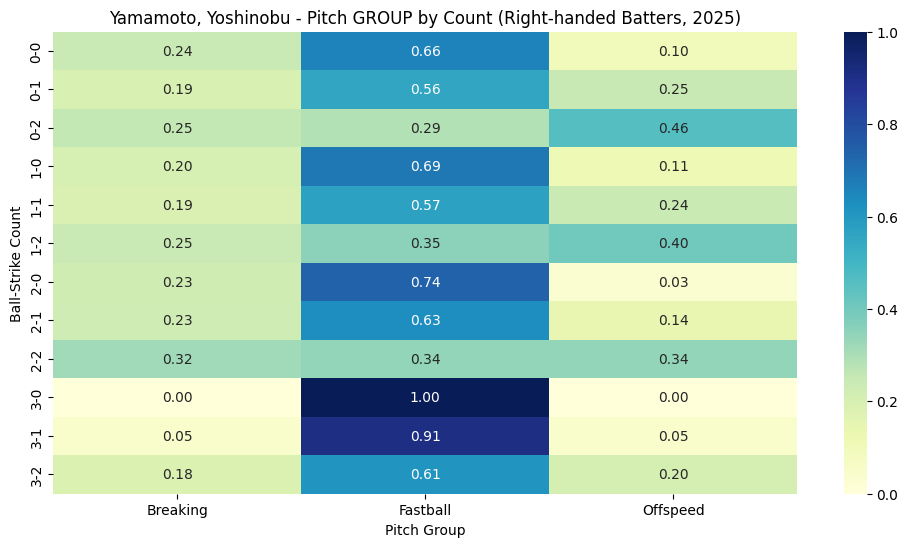

In [13]:
print("\n📊 좌타 / 우타 별 볼카운트 × 구종 그룹 Heatmap 생성 중...")

df_lr = data[(data["pitcher"] == pitcher_id) & (data["pitch_type"].notna())].copy()
df_lr = df_lr[['pitch_type', 'balls', 'strikes', 'stand']].dropna()
df_lr = df_lr[(df_lr['balls'] <= 3) & (df_lr['strikes'] <= 2)]
df_lr['count'] = df_lr['balls'].astype(str) + '-' + df_lr['strikes'].astype(str)

# pitch_type → pitch_group 변환
df_lr['pitch_group'] = df_lr['pitch_type'].map(pitch_type_group_map).fillna("Other")

for hand, label in [('L', 'Left-handed Batters'), ('R', 'Right-handed Batters')]:
    sub = df_lr[df_lr['stand'] == hand]
    if sub.empty:
        print(f"\n⚠️ {label} 데이터가 없습니다.")
        continue

    count_pitch = pd.crosstab(
        sub['count'],
        sub['pitch_group'],
        normalize='index'
    )

    plt.figure(figsize=(12, 6))
    sns.heatmap(count_pitch, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title(f"{pitcher_name} - Pitch GROUP by Count ({label}, {selected_year})")
    plt.xlabel("Pitch Group")
    plt.ylabel("Ball-Strike Count")
    plt.show()

### 좌타 / 우타 별 볼카운트 × 구종 Heatmap (예측 데이터)


🔮 예측 기반 좌타/우타 × 볼카운트 × 구종 Heatmap 생성 중...

📌 XGBoost Predicted Prob


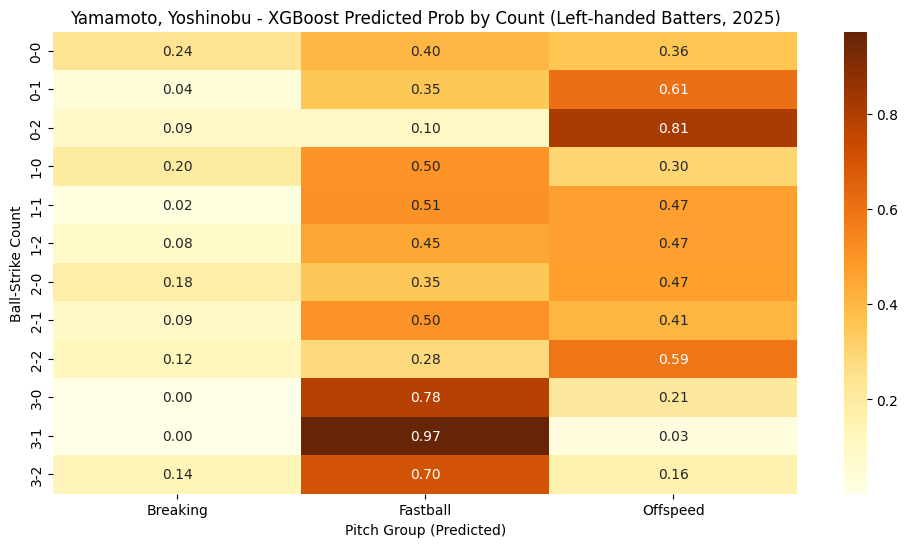

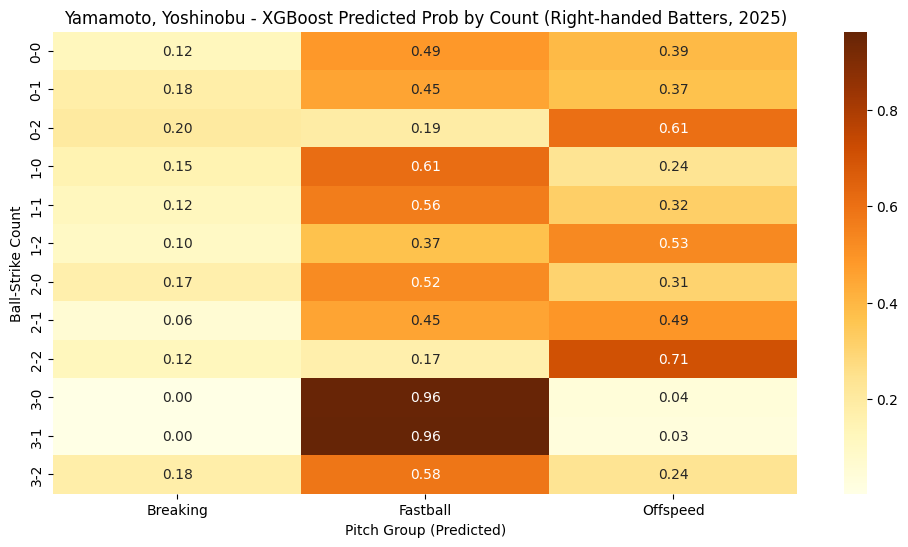


📌 AutoGluon Predicted Prob


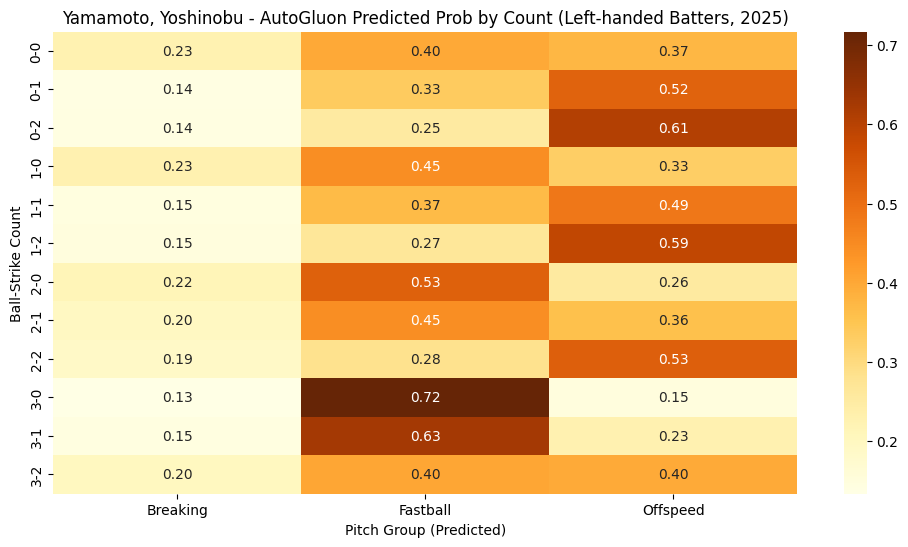

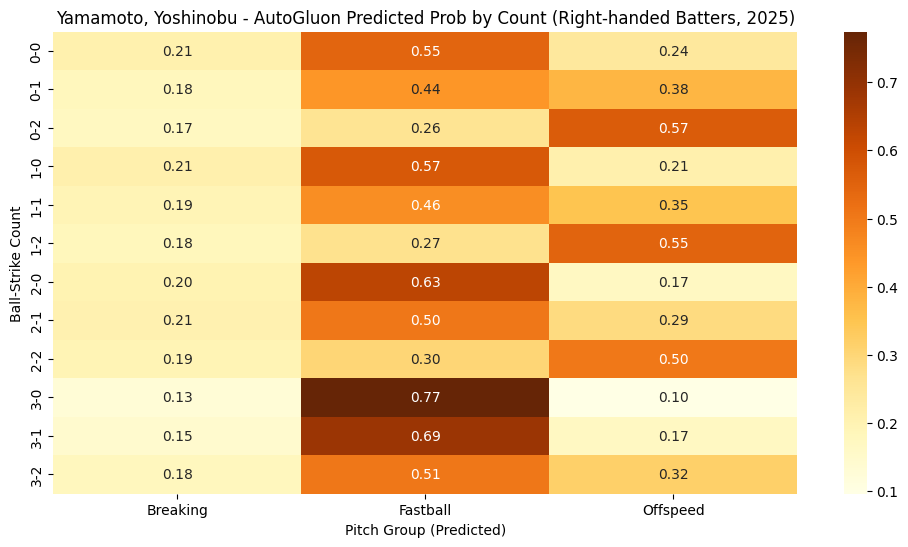


📌 Ensemble Predicted Prob


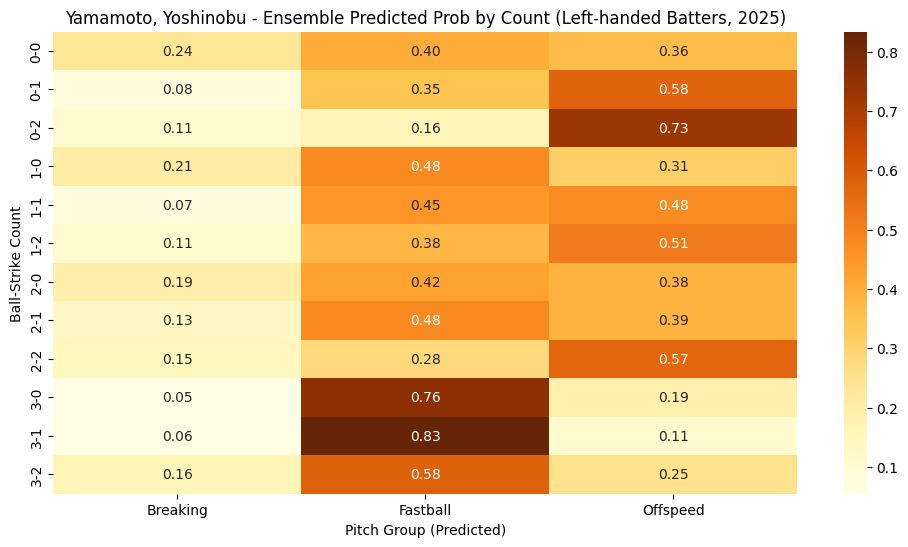

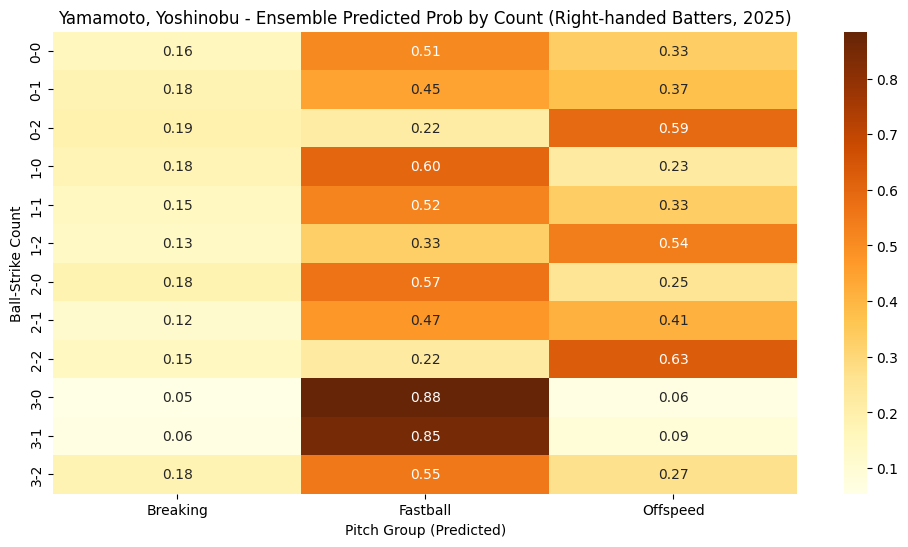

In [14]:
# 🔧 예측 확률 컬럼 자동 수집
model_sections = {
    "XGBoost Predicted Prob":   [col for col in pred_df.columns if col.startswith("xgb_")],
    "AutoGluon Predicted Prob": [col for col in pred_df.columns if col.startswith("ag_")],
    "Ensemble Predicted Prob":  [col for col in pred_df.columns if col.startswith("ens_")],
}

# stand 값이 숫자(0=L, 1=R)인지 확인
pred_df["stand"] = pred_df["stand"].map({"L": 0, "R": 1}).fillna(pred_df["stand"]).astype(int)

# count 형식 수정
pred_df["count"] = pred_df["balls"].astype(str) + "-" + pred_df["strikes"].astype(str)

print("\n🔮 예측 기반 좌타/우타 × 볼카운트 × 구종 Heatmap 생성 중...")

hand_map = {0: "Left-handed Batters", 1: "Right-handed Batters"}

for model_name, cols in model_sections.items():

    print(f"\n📌 {model_name}")

    for hand, label in hand_map.items():
        sub = pred_df[pred_df["stand"] == hand]
        if sub.empty:
            print(f"⚠️ {label} 데이터 없음")
            continue

        pivot = pd.pivot_table(
            sub,
            values=cols,
            index="count",
            aggfunc="mean"
        )

        pivot.columns = [c.split("_", 1)[1] for c in cols]

        plt.figure(figsize=(12, 6))
        sns.heatmap(pivot, annot=True, cmap="YlOrBr", fmt=".2f")
        plt.title(f"{pitcher_name} - {model_name} by Count ({label}, {selected_year})")
        plt.xlabel("Pitch Group (Predicted)")
        plt.ylabel("Ball-Strike Count")
        plt.show()

### 🏃 주자 상황 × 볼카운트 × 구종 Heatmap (실제 데이터)
주자 상황(주자 없음, 1루, 만루 등)에 따른 실제 구종 분포를 볼카운트별로 시각화합니다. 주자가 있을 때 투수가 어떤 구종을 던지는지 분석할 수 있습니다.


📊 주자 상황 × 볼카운트 × 구종 그룹 Heatmap 생성 중...


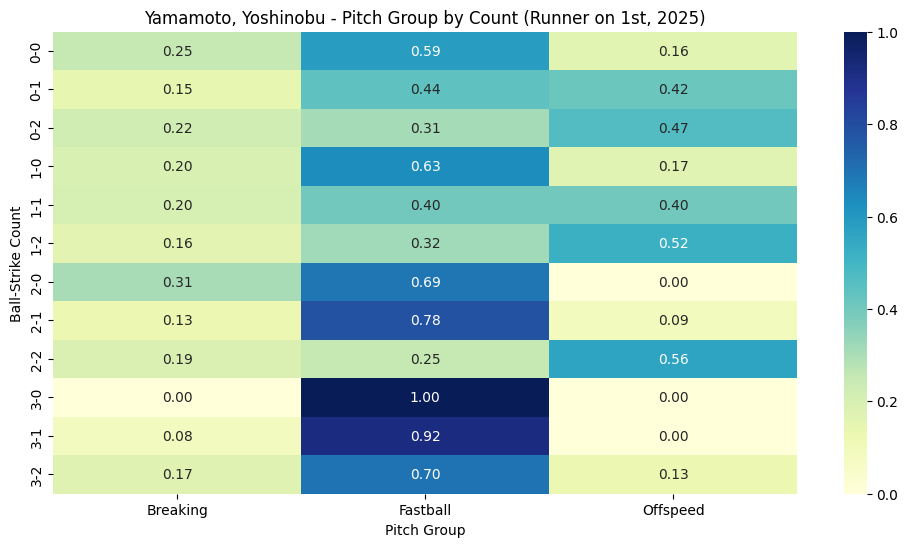

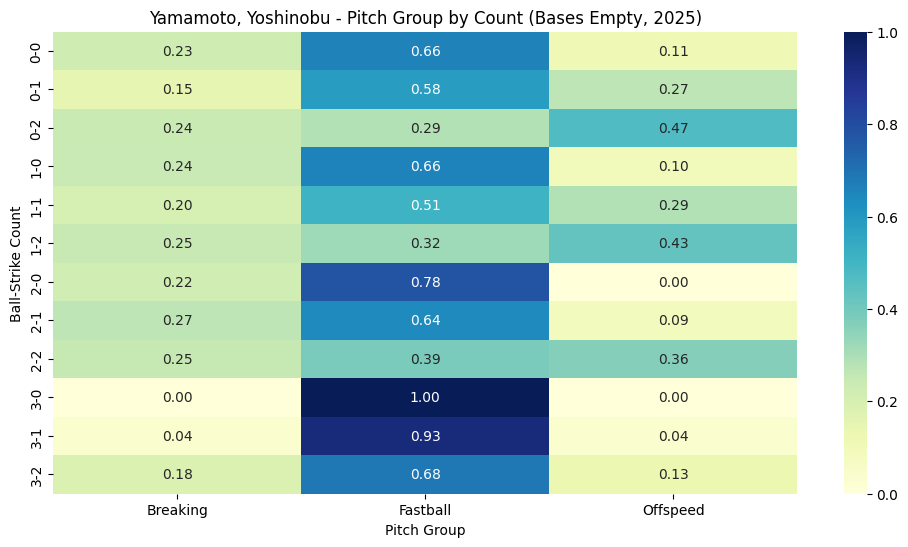

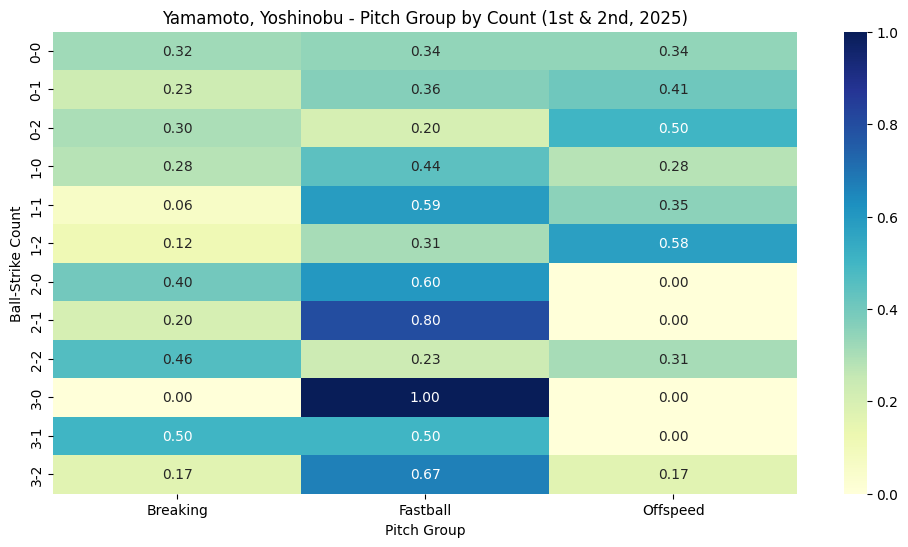

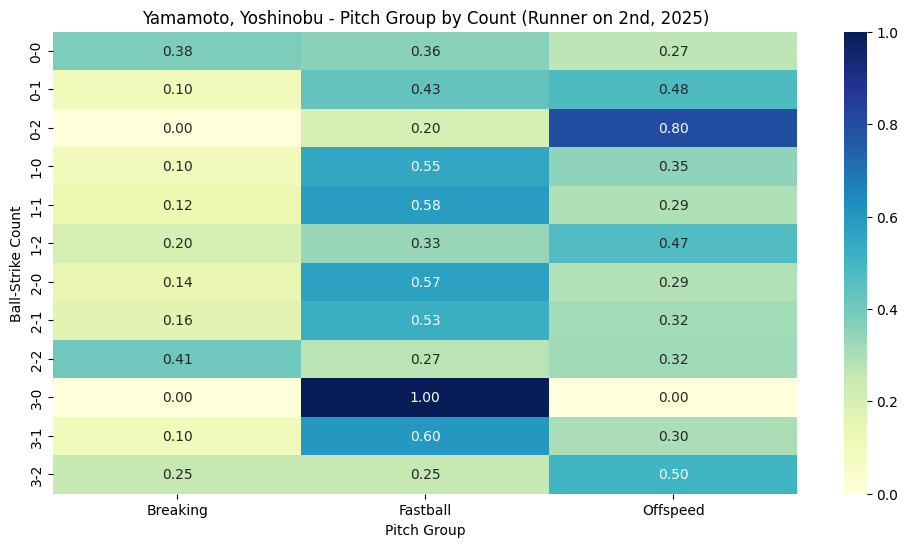

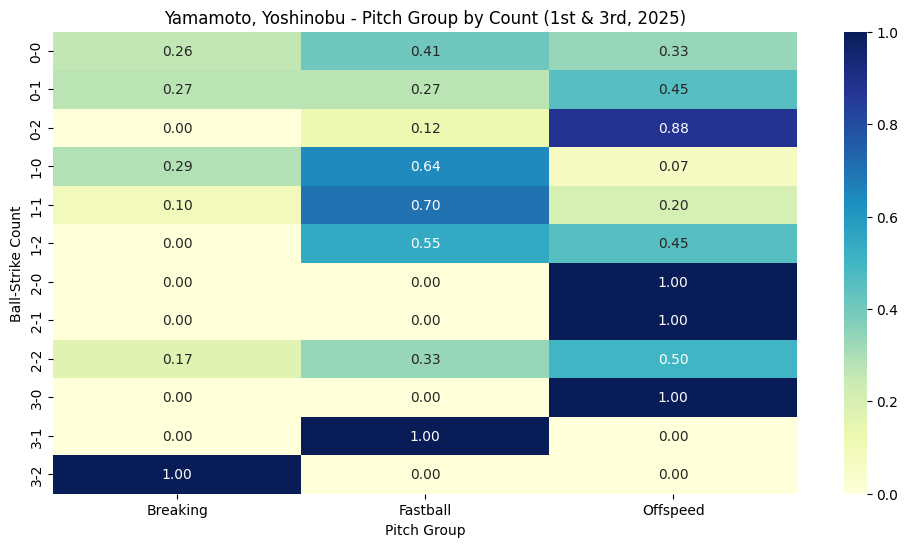

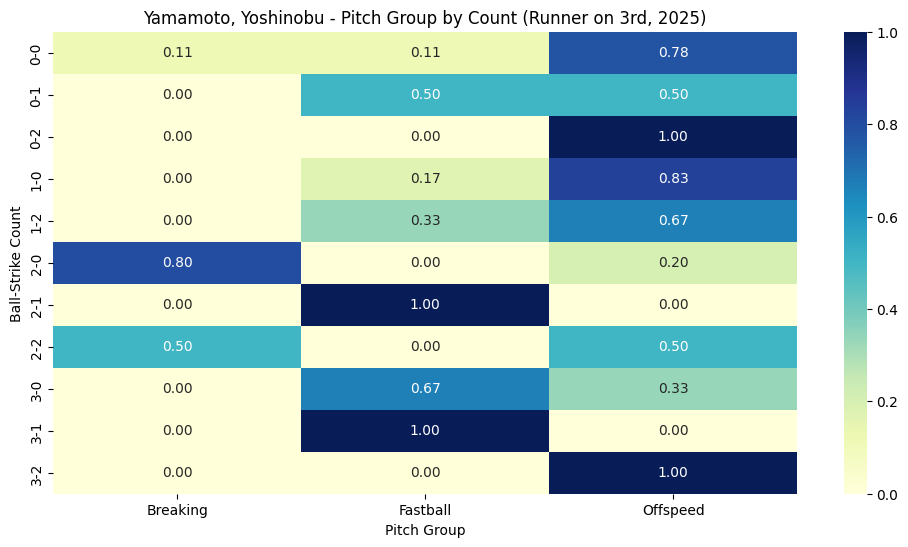

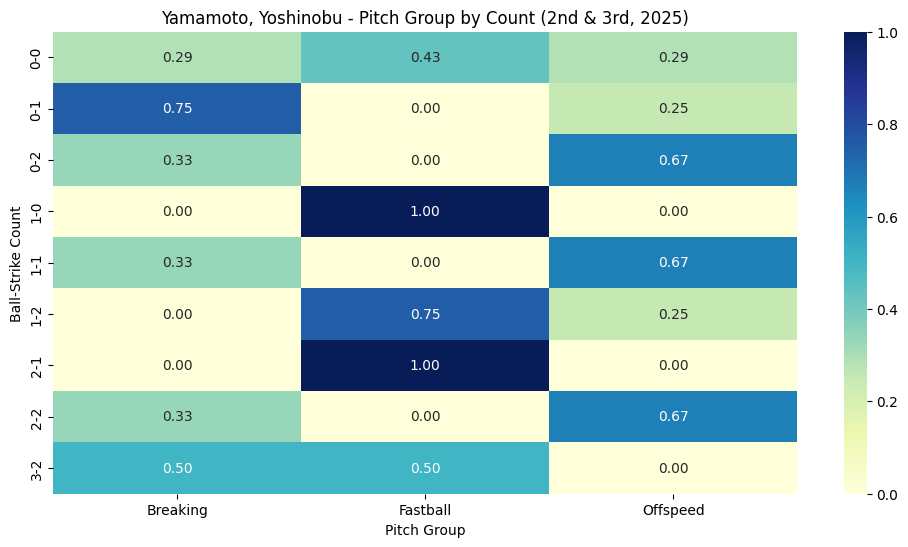

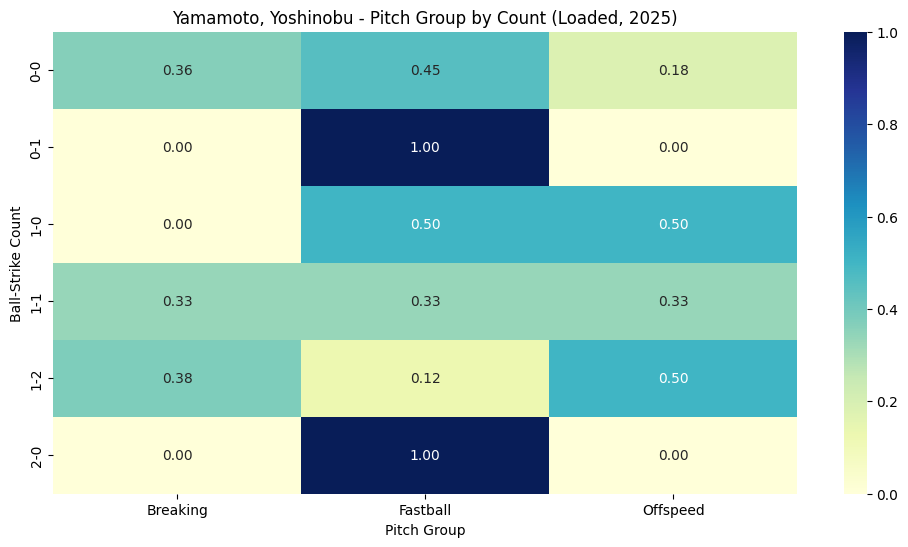

In [15]:
print("\n📊 주자 상황 × 볼카운트 × 구종 그룹 Heatmap 생성 중...")

df_bases = data[(data["pitcher"] == pitcher_id) & (data["pitch_type"].notna())].copy()
df_bases = df_bases[['pitch_type', 'balls', 'strikes', 'on_1b', 'on_2b', 'on_3b']].dropna(subset=['pitch_type'])

# Runner 0/1 처리
for b in ['on_1b', 'on_2b', 'on_3b']:
    df_bases[b] = df_bases[b].apply(lambda x: 0 if pd.isna(x) else 1)

# 정상 카운트
df_bases = df_bases[(df_bases['balls'] <= 3) & (df_bases['strikes'] <= 2)]
df_bases['count'] = df_bases['balls'].astype(int).astype(str) + "-" + df_bases['strikes'].astype(int).astype(str)

# 베이스 상태 문자열
def base_state(row):
    return f"{'1' if row['on_1b'] else '-'}" + \
           f"{'2' if row['on_2b'] else '-'}" + \
           f"{'3' if row['on_3b'] else '-'}"

df_bases['base_state'] = df_bases.apply(base_state, axis=1)

base_state_label = {
    '---': 'Bases Empty',
    '1--': 'Runner on 1st',
    '-2-': 'Runner on 2nd',
    '--3': 'Runner on 3rd',
    '12-': '1st & 2nd',
    '1-3': '1st & 3rd',
    '-23': '2nd & 3rd',
    '123': 'Loaded'
}

df_bases['base_state_label'] = df_bases['base_state'].map(base_state_label).fillna(df_bases['base_state'])

# pitch_type → pitch_group (새로운 모델 기준)
df_bases['pitch_type_full'] = df_bases['pitch_type'].map(pitch_type_group_map).fillna("Other")

# Heatmap 생성
for bs in df_bases['base_state_label'].unique():
    sub = df_bases[df_bases['base_state_label'] == bs]
    if sub.empty:
        continue

    count_pitch = pd.crosstab(
        sub['count'],
        sub['pitch_type_full'],
        normalize='index'
    )

    plt.figure(figsize=(12, 6))
    sns.heatmap(count_pitch, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title(f"{pitcher_name} - Pitch Group by Count ({bs}, {selected_year})")
    plt.xlabel("Pitch Group")
    plt.ylabel("Ball-Strike Count")
    plt.show()

### 🏃 주자 상황 × 볼카운트 × 구종 Heatmap (예측 데이터)

아래 코드는 실제 데이터 Heatmap 코드와 완벽히 동일한 구조이며,
count × base_state × pitch_group_prob 평균 heatmap으로 예측 결과를 보여준다.


🔮 예측 기반 주자 상황 × 볼카운트 × 구종 그룹 Heatmap 생성 중...

📌 XGBoost Predicted Prob


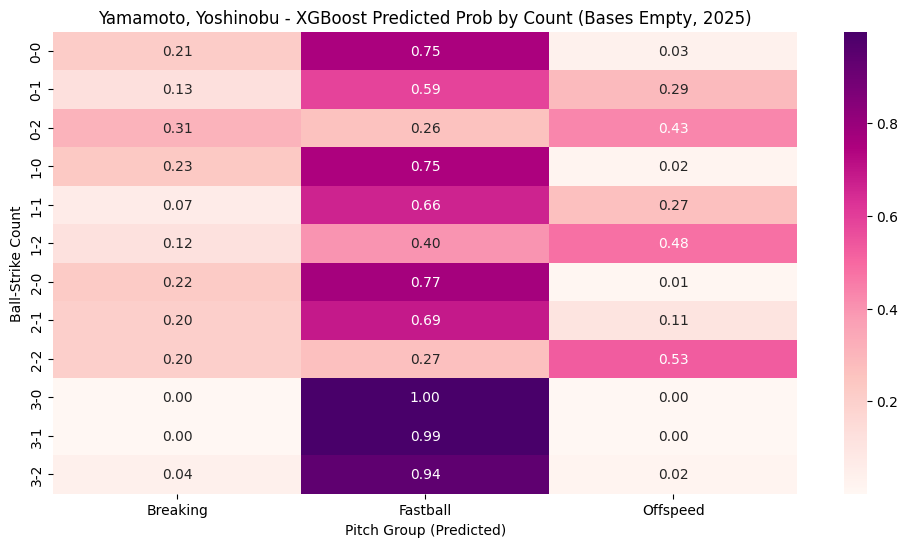

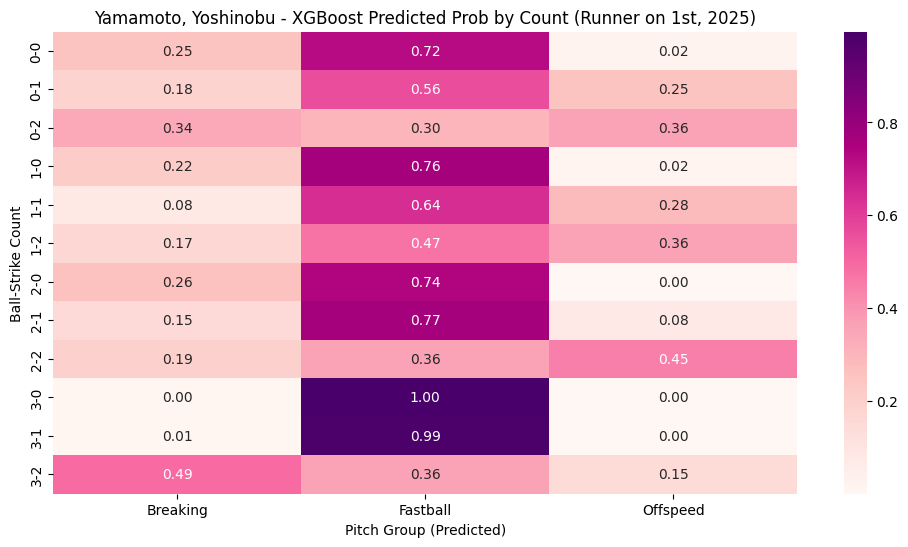

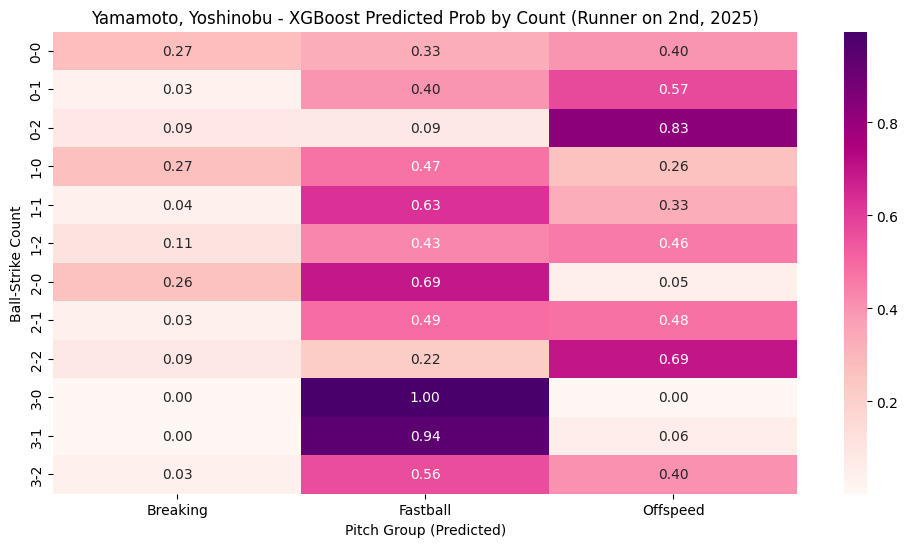

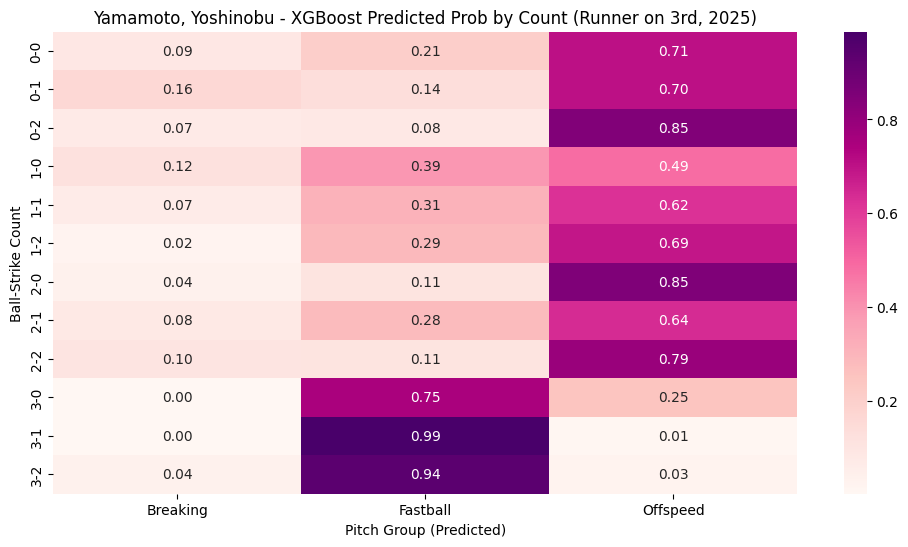

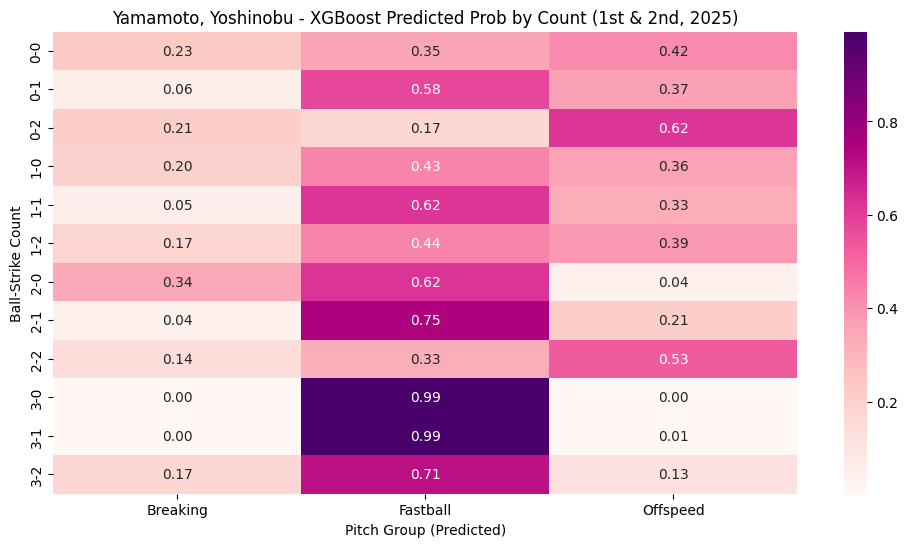

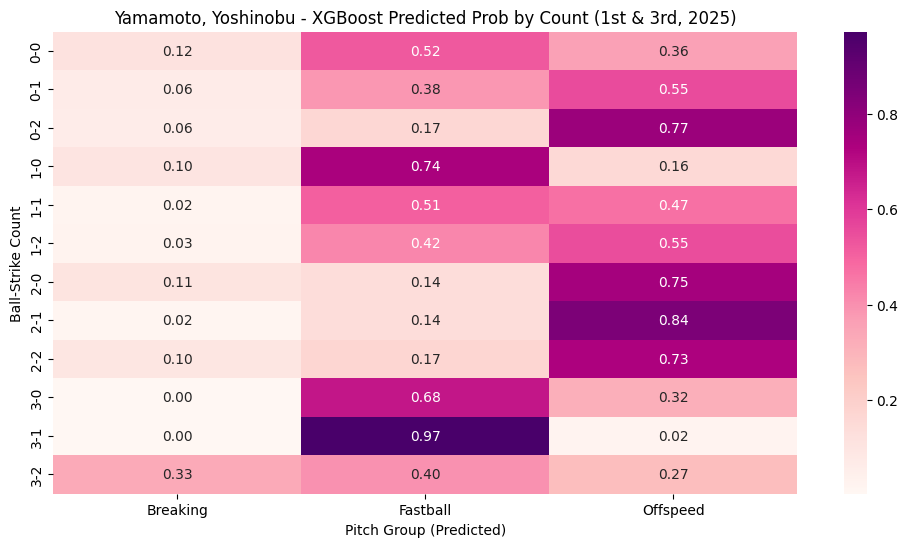

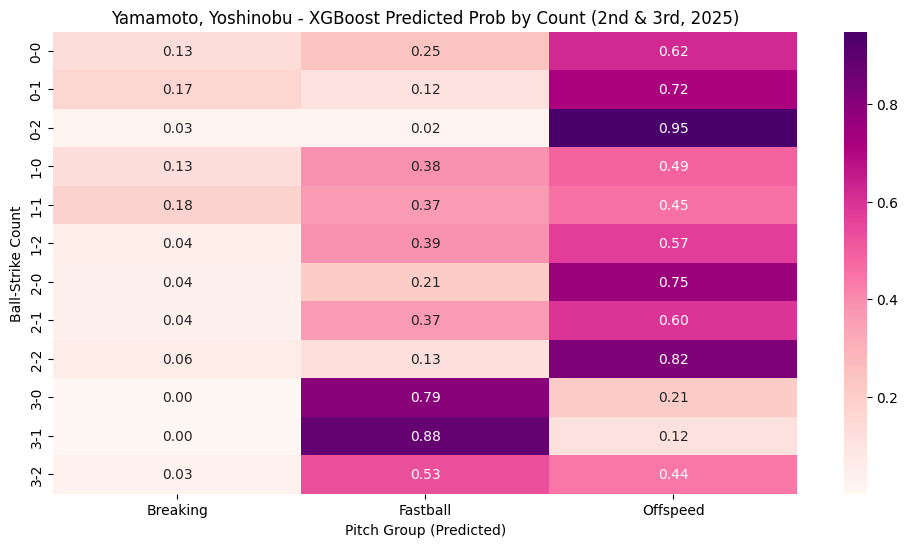

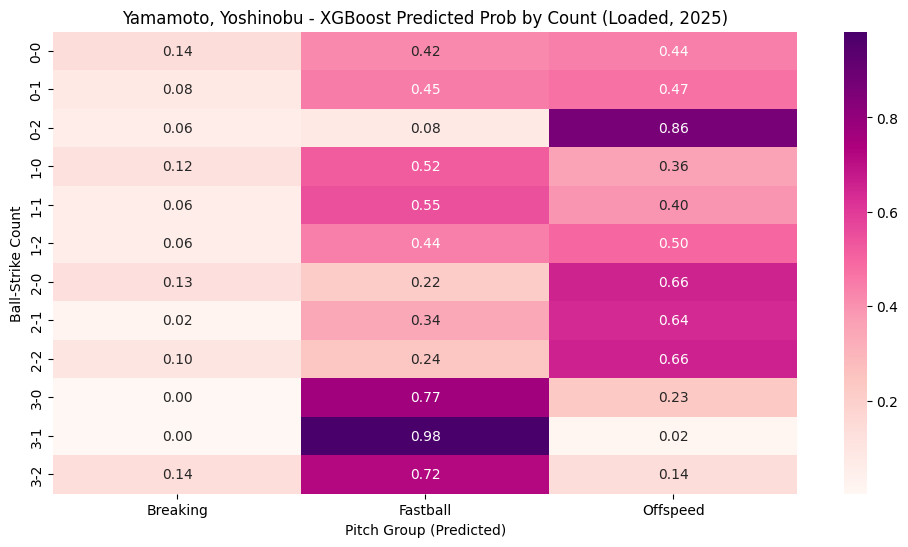


📌 AutoGluon Predicted Prob


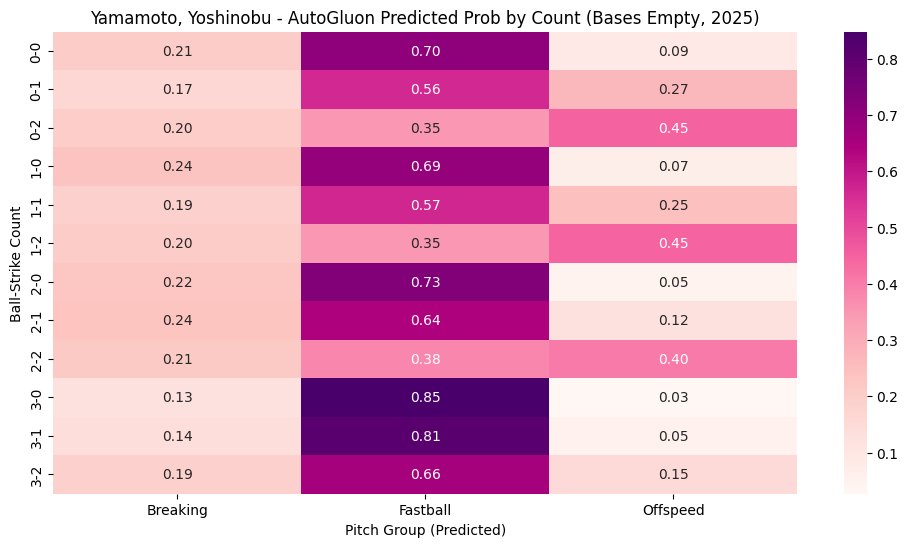

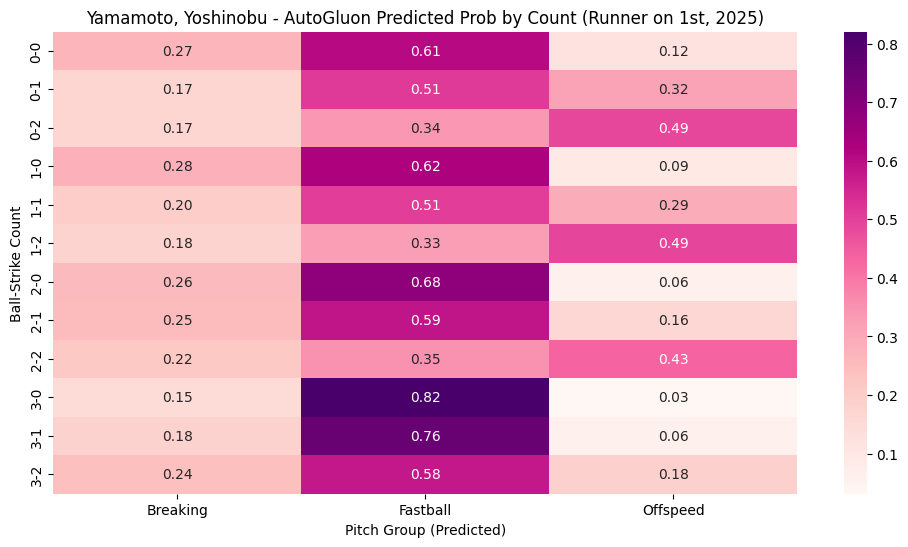

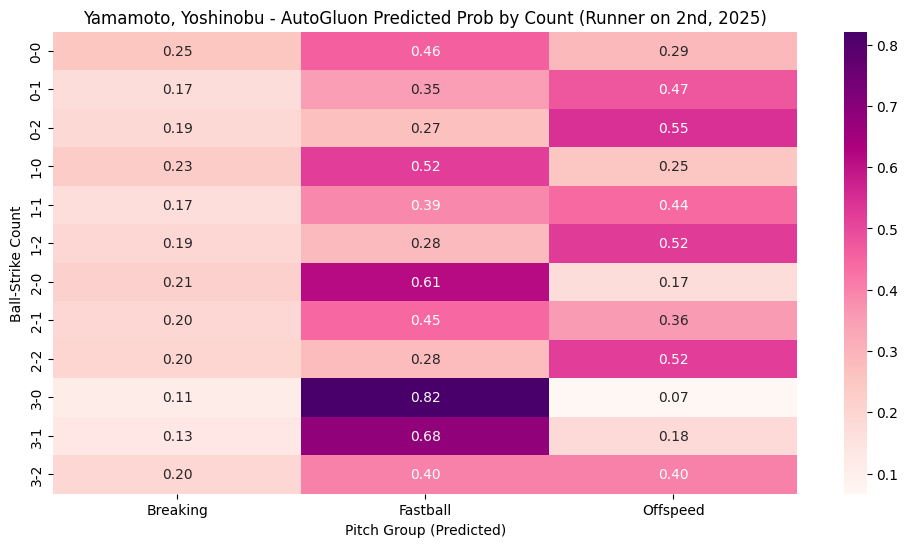

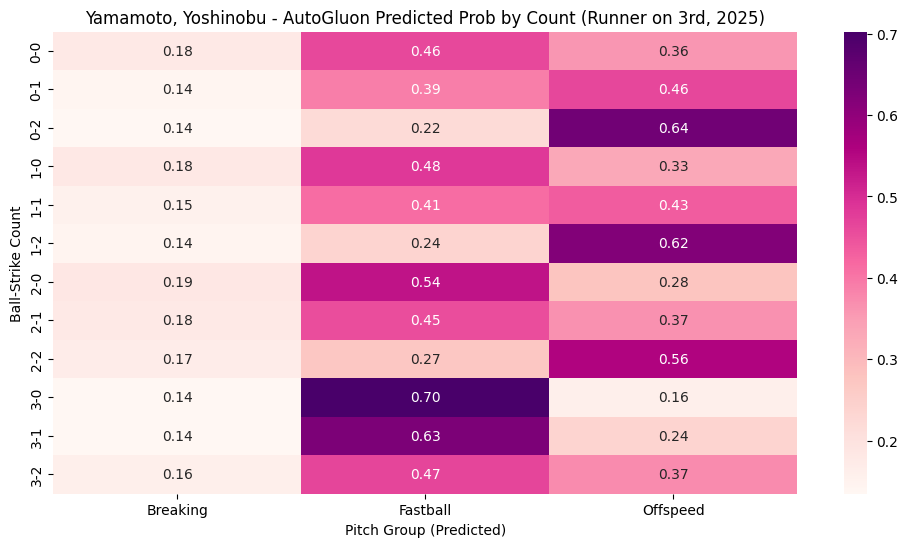

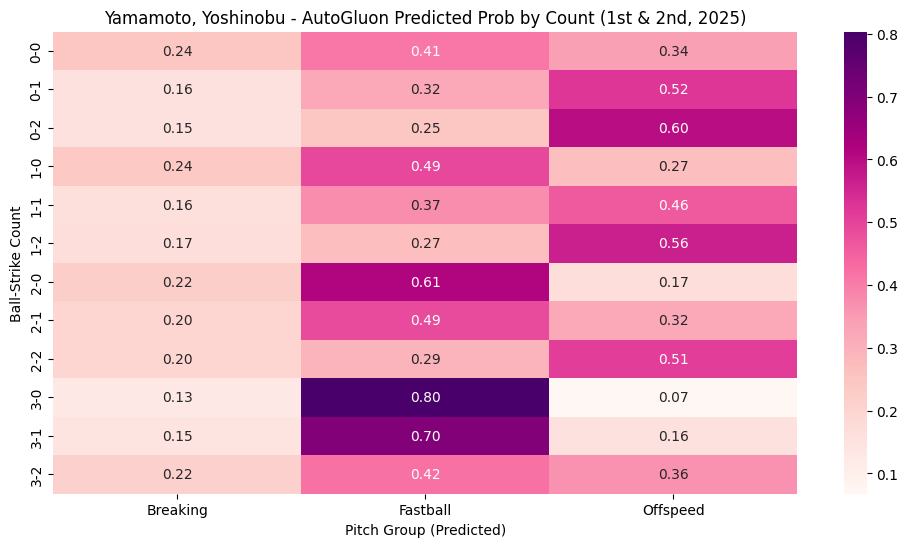

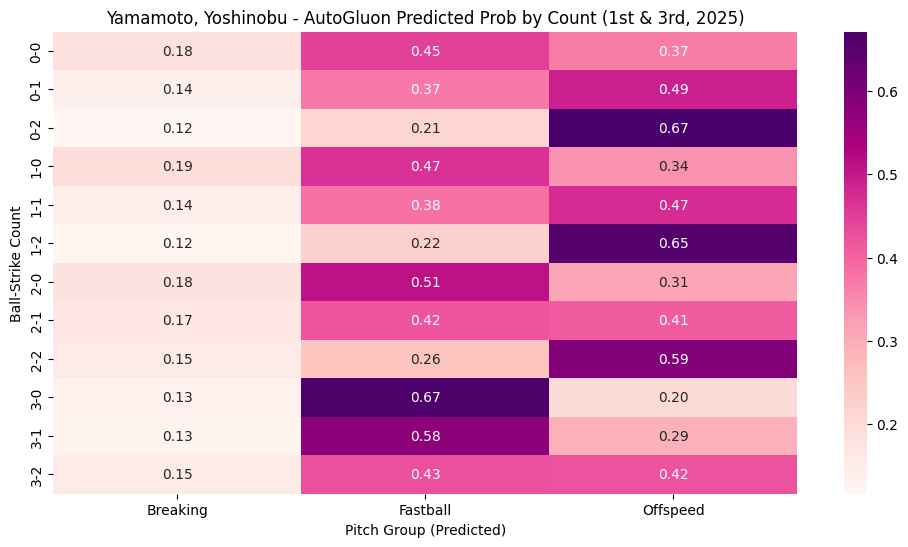

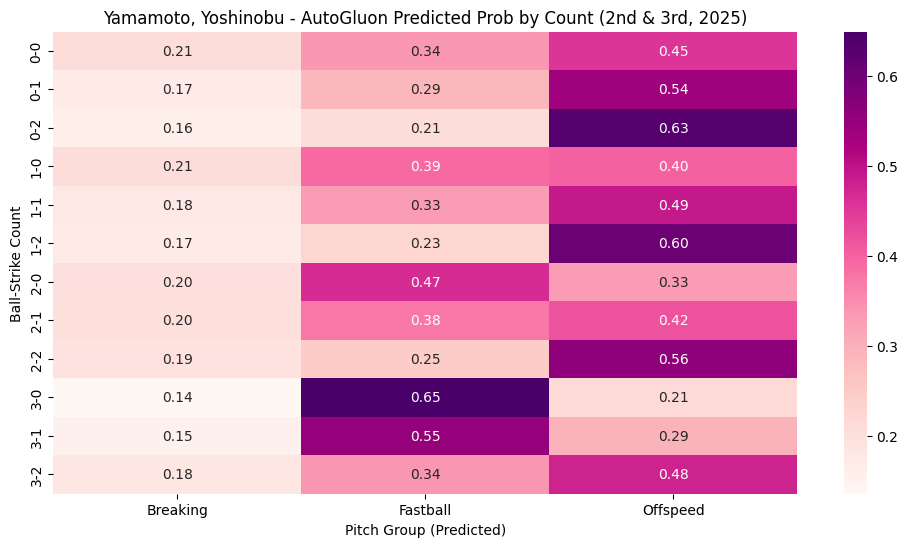

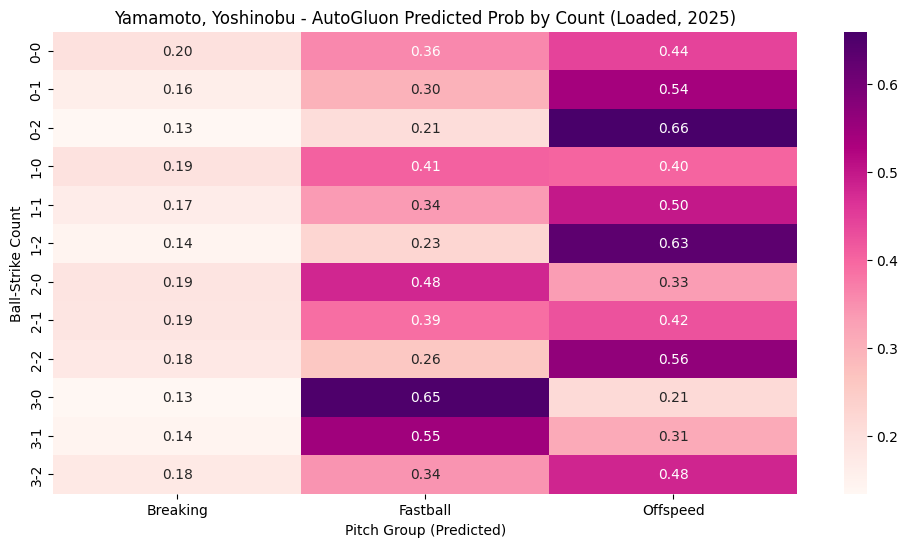


📌 Ensemble Predicted Prob


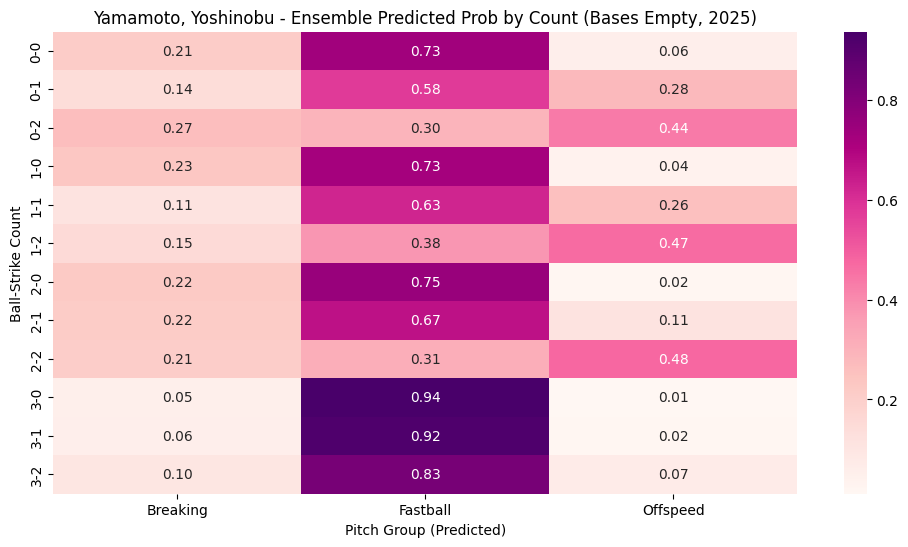

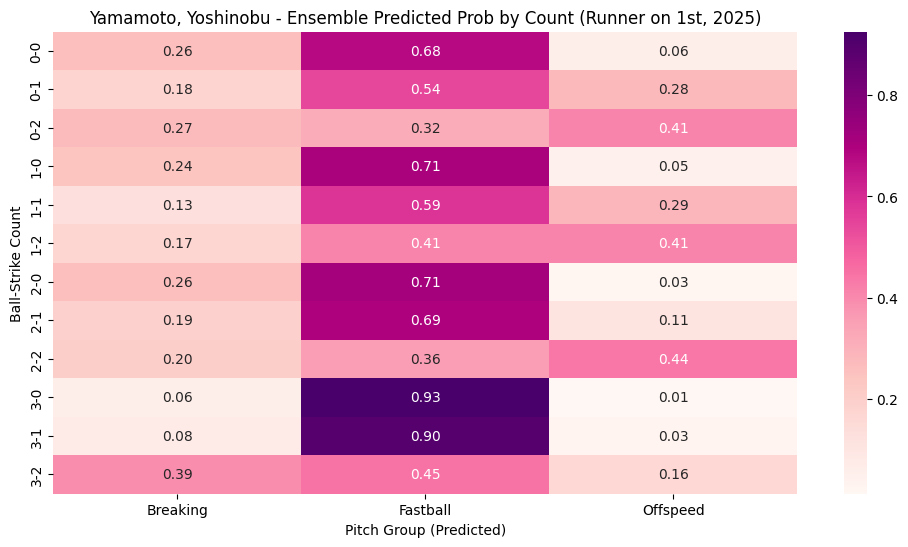

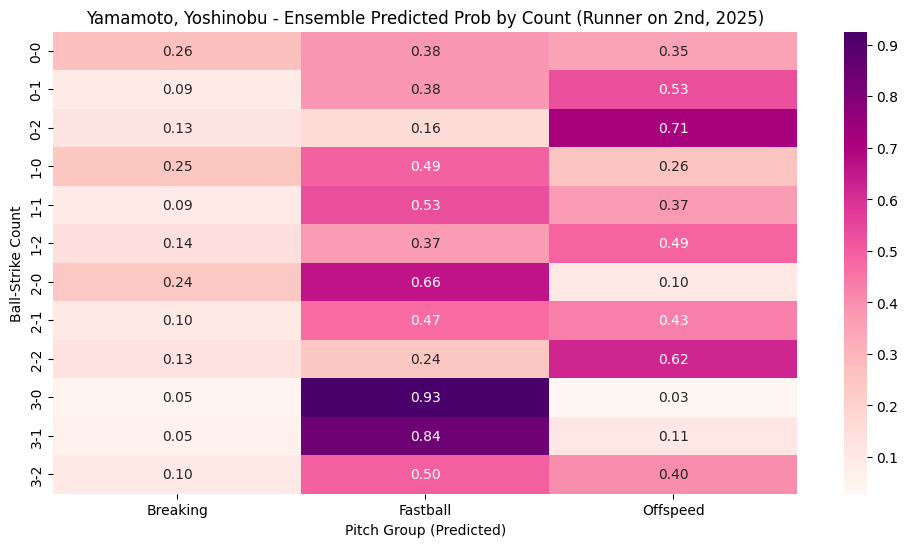

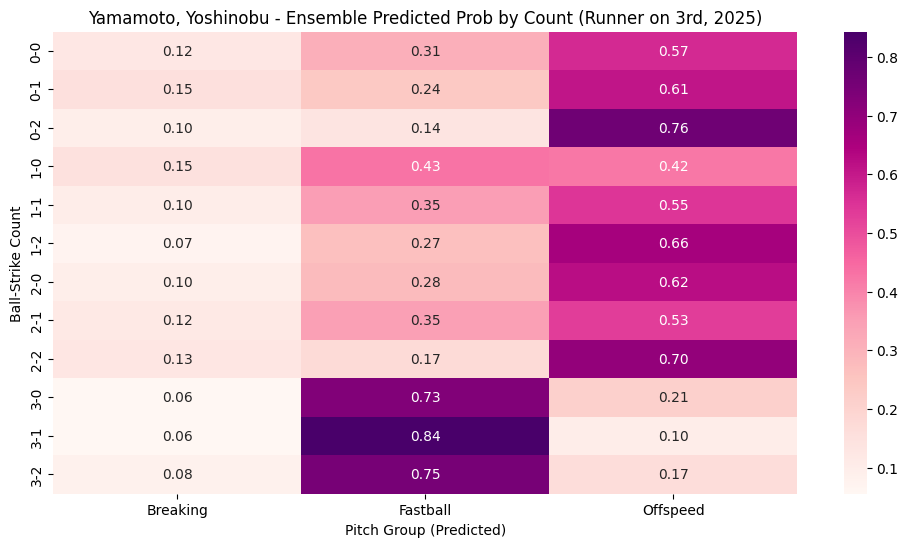

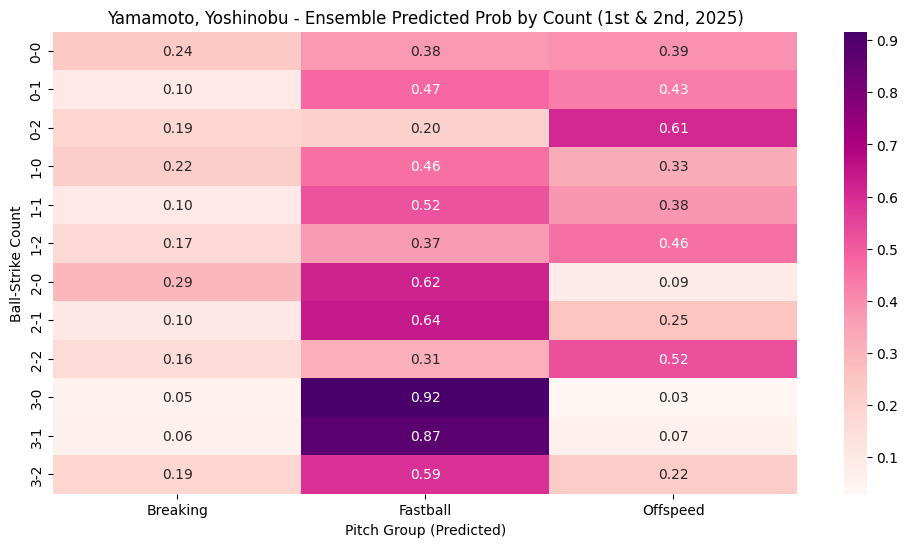

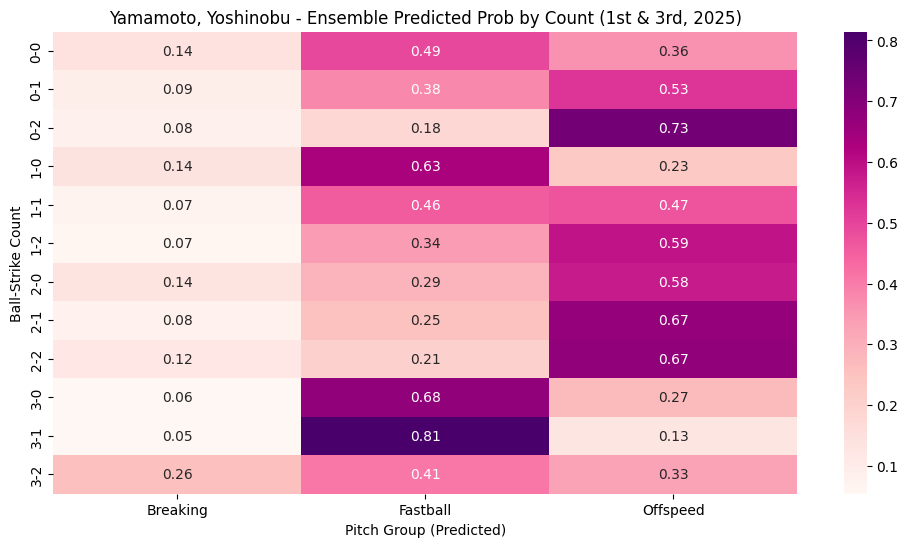

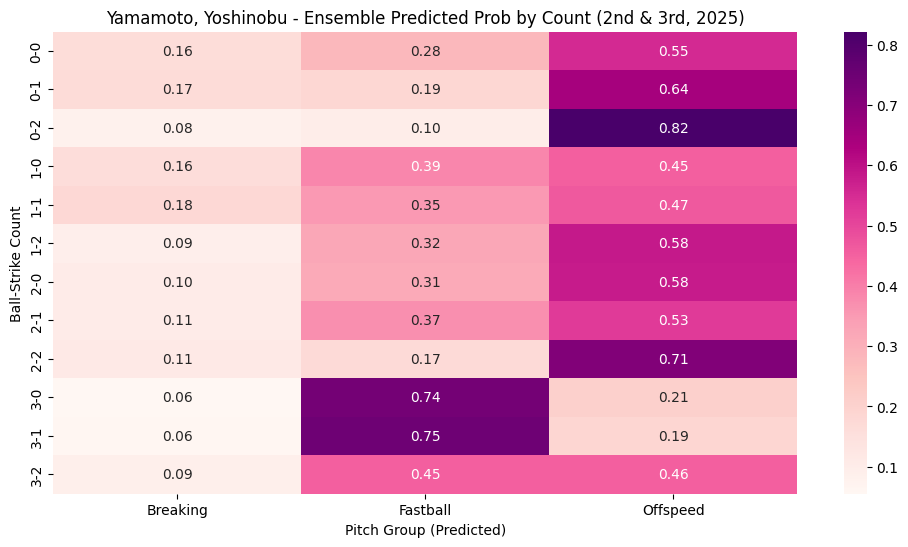

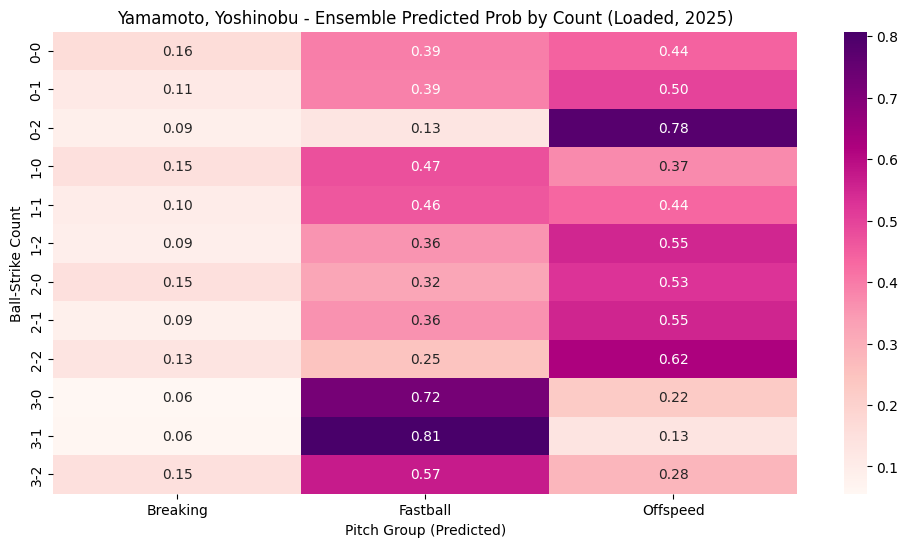

In [16]:
# ------------------------------------------
# 🏃 주자상황 × 볼카운트 × 구종 Heatmap (예측 데이터)
# ------------------------------------------

print("\n🔮 예측 기반 주자 상황 × 볼카운트 × 구종 그룹 Heatmap 생성 중...")

def base_state_pred(row):
    return f"{'1' if row['on_1b'] else '-'}" + \
           f"{'2' if row['on_2b'] else '-'}" + \
           f"{'3' if row['on_3b'] else '-'}"

pred_df["base_state"] = pred_df.apply(base_state_pred, axis=1)
pred_df["base_state_label"] = pred_df["base_state"].map(base_state_label).fillna(pred_df["base_state"])

# 🎨 모델별 Heatmap
model_sections = {
    "XGBoost Predicted Prob":      [col for col in pred_df.columns if col.startswith("xgb_")],
    "AutoGluon Predicted Prob":    [col for col in pred_df.columns if col.startswith("ag_")],
    "Ensemble Predicted Prob":     [col for col in pred_df.columns if col.startswith("ens_")],
}

for model_name, cols in model_sections.items():

    print(f"\n📌 {model_name}")

    for bs in pred_df['base_state_label'].unique():
        sub = pred_df[pred_df['base_state_label'] == bs]
        if sub.empty:
            continue

        pivot = pd.pivot_table(
            sub,
            values=cols,
            index="count",
            aggfunc="mean"
        )

        pivot.columns = [c.split("_", 1)[1] for c in cols]

        plt.figure(figsize=(12, 6))
        sns.heatmap(pivot, annot=True, cmap="RdPu", fmt=".2f")
        plt.title(f"{pitcher_name} - {model_name} by Count ({bs}, {selected_year})")
        plt.xlabel("Pitch Group (Predicted)")
        plt.ylabel("Ball-Strike Count")
        plt.show()

###📊 2D Heatmap: Count × Base State × BatterSide 앙상블 정확도 분석

이 분석 파트는 주자 상황(Base State), 타자의 스탠스(좌/우타), 그리고 볼카운트(B-S Count)를 조합하여
앙상블 모델(XGBoost + AutoGluon)의 예측 정확도(실제 구종 = 예측 구종 비율)를
2차원 Heatmap으로 시각화한 것입니다.


📊 2D Heatmap: Count × Base State × BatterSide 정확도 생성 중...


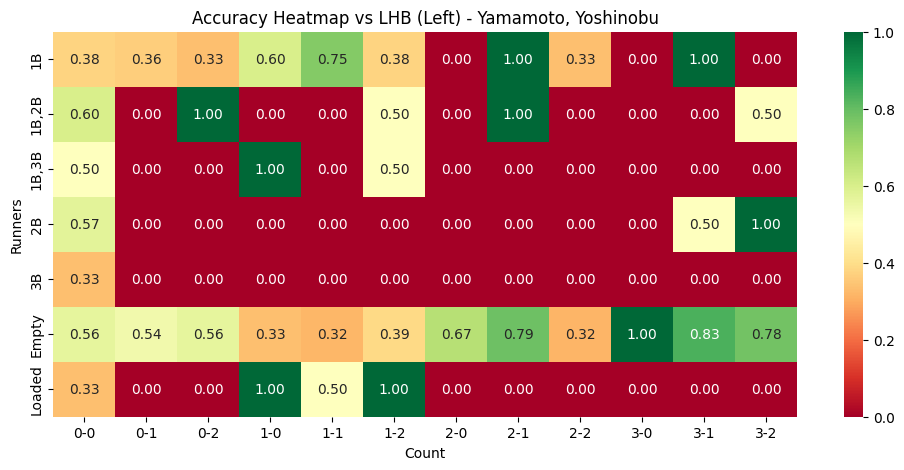

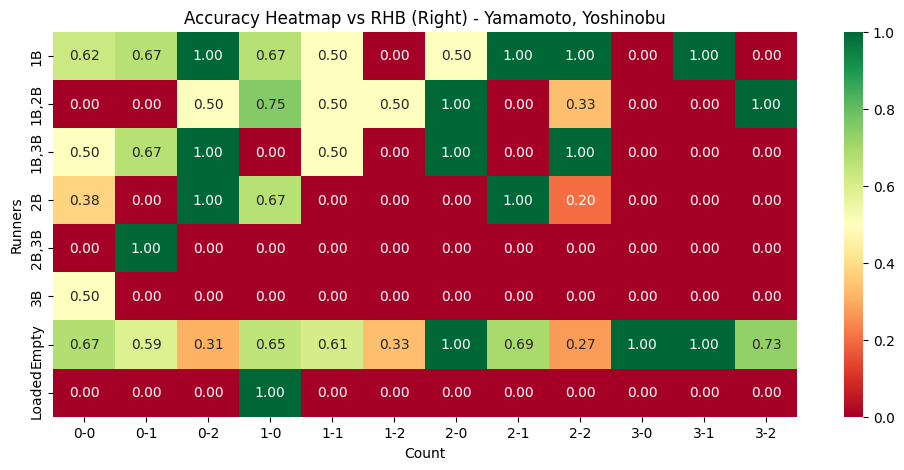

In [17]:
print("\n📊 2D Heatmap: Count × Base State × BatterSide 정확도 생성 중...")

eval_df = X_test.copy()
eval_df["true"] = y_test
eval_df["pred"] = ens_series       # ← 수정된 부분
eval_df["correct"] = (eval_df["true"] == eval_df["pred"]).astype(float)

# 베이스 상태 label
def get_base_state(r):
    return ("1" if r["on_1b"] else "-") + \
           ("2" if r["on_2b"] else "-") + \
           ("3" if r["on_3b"] else "-")

eval_df["base_code"] = eval_df.apply(get_base_state, axis=1)

base_map = {
    "---": "Empty", "1--": "1B", "-2-": "2B", "--3": "3B",
    "12-": "1B,2B", "1-3": "1B,3B", "-23": "2B,3B", "123": "Loaded"
}

eval_df["base_label"] = eval_df["base_code"].map(base_map)
eval_df["count"] = eval_df["balls"].astype(int).astype(str) + "-" + eval_df["strikes"].astype(int).astype(str)
eval_df["batter_hand"] = eval_df["stand"].map({0: "LHB (Left)", 1: "RHB (Right)"})

# 좌타/우타 Heatmap
for hand in ["LHB (Left)", "RHB (Right)"]:
    sub = eval_df[eval_df["batter_hand"] == hand]
    if sub.empty: continue

    pivot = sub.pivot_table(
        index="base_label", columns="count", values="correct", aggfunc="mean"
    ).fillna(0)

    plt.figure(figsize=(12, 5))
    sns.heatmap(pivot, annot=True, cmap="RdYlGn", fmt=".2f", vmin=0, vmax=1)
    plt.title(f"Accuracy Heatmap vs {hand} - {pitcher_name}")
    plt.ylabel("Runners")
    plt.xlabel("Count")
    plt.show()

### 🔄 실시간 구종 예측 함수
주어진 경기 상황(볼카운트, 이닝, 점수, 주자 유무, 타자 및 투수 손잡이)을 입력받아 투수의 구종별 예측 확률을 반환하는 함수를 정의합니다. 실제 경기 중 특정 상황에서 어떤 구종이 나올지 예측하는 데 활용할 수 있습니다.

In [18]:
def predict_pitch_realtime_group(
    balls,
    strikes,
    outs_when_up,
    inning,
    home_score,
    away_score,
    on_1b,
    on_2b,
    on_3b,
    stand,      # 'L' or 'R'
    p_throws,   # 'L' or 'R'
    w_xgb=0.6,
    w_ag=0.4
):
    """
    현재 경기 상황에서 Fastball / Breaking / Offspeed / Other
    그룹 구종 확률을 앙상블로 예측하는 함수.
    """

    # -----------------------------
    # 1) 입력 DF 생성
    # -----------------------------
    input_df = pd.DataFrame([{
        "balls": balls,
        "strikes": strikes,
        "outs_when_up": outs_when_up,
        "inning": inning,
        "home_score": home_score,
        "away_score": away_score,
        "on_1b": int(bool(on_1b)),
        "on_2b": int(bool(on_2b)),
        "on_3b": int(bool(on_3b)),
        "stand": 0 if stand == "L" else 1,
        "p_throws": 0 if p_throws == "L" else 1
    }])[feature_cols].astype(np.float32)

    # -----------------------------
    # 2) 개별 모델 확률
    # -----------------------------
    proba_x = xgb_model.predict_proba(input_df)
    proba_a = predictor.predict_proba(input_df)

    proba_x_df = pd.DataFrame(proba_x, columns=pitch_labels)
    proba_a_df = proba_a[pitch_labels]

    final_probs_raw = w_xgb * proba_x_df.values + w_ag * proba_a_df.values
    final_probs_raw = final_probs_raw[0]

    # -----------------------------
    # 3) 개별 구종 → 그룹 구종 매핑
    # -----------------------------
    group_sums = {"Fastball": 0, "Breaking": 0, "Offspeed": 0, "Other": 0}

    for pitch_code, prob in zip(pitch_labels, final_probs_raw):
        group_name = pitch_type_group_map.get(pitch_code, "Other")
        group_sums[group_name] += prob

    group_df = pd.DataFrame({
        "Group": group_sums.keys(),
        "Probability": group_sums.values()
    }).sort_values("Probability", ascending=False)

    # -----------------------------
    # 4) 출력
    # -----------------------------
    print(f"\n🎯 Current Situation Prediction (Grouped) - {pitcher_name} ({selected_year})")
    print(group_df.to_string(index=False,
                             formatters={"Probability": lambda x: f"{x:.3f}"}))

    return group_df

In [19]:
predict_pitch_realtime_group(
    balls=2,
    strikes=1,
    outs_when_up=1,
    inning=5,
    home_score=3,
    away_score=2,
    on_1b=True,
    on_2b=False,
    on_3b=False,
    stand="L",
    p_throws="R"
)


🎯 Current Situation Prediction (Grouped) - Yamamoto, Yoshinobu (2025)
   Group Probability
   Other       1.000
Fastball       0.000
Breaking       0.000
Offspeed       0.000


,Group,Probability
3,Other,1.0
0,Fastball,0.0
1,Breaking,0.0
2,Offspeed,0.0


### 📋 모든 상황(Count × Base × Stand) 전략 시트 생성
모든 가능한 경기 상황(볼카운트, 주자 상황, 타자 스탠스)에 대한 1, 2순위 예측 구종과 그 확률을 계산하여 전략 시트를 생성하고 CSV 파일로 저장합니다. 이는 경기 중 실시간 전략 수립에 매우 유용합니다.

In [20]:
import itertools

print("\n📊 모든 가능한 경기 상황에 대한 '구종 전략 시트' 생성 중... (Batch Prediction)")

# 1. 고정 변수
fixed_feats = {
    "outs_when_up": 0,
    "inning": 1,
    "home_score": 0,
    "away_score": 0,
    "p_throws": df['p_throws'].iloc[0]
}

# 2. 변수 범위 설정
balls_range = [0, 1, 2, 3]
strikes_range = [0, 1, 2]
stand_range = [0, 1]  # 0: 좌타, 1: 우타

runner_states = [
    (0, 0, 0),
    (1, 0, 0),
    (0, 1, 0),
    (0, 0, 1),
    (1, 1, 0),
    (1, 0, 1),
    (0, 1, 1),
    (1, 1, 1)
]

# 3. 모든 조합 생성 (192가지)
combinations = list(itertools.product(stand_range, runner_states, balls_range, strikes_range))

# 4. 입력 DF 생성
batch_rows = []
for stand, (r1, r2, r3), b, s in combinations:
    row = fixed_feats.copy()
    row.update({
        "balls": b, "strikes": s, "stand": stand,
        "on_1b": r1, "on_2b": r2, "on_3b": r3
    })
    batch_rows.append(row)

batch_df = pd.DataFrame(batch_rows)
batch_df = batch_df[X_train.columns].astype(np.float32)

# 5. 예측
print(f"🚀 총 {len(batch_df)}개 상황에 대해 일괄 예측 수행...")
proba_x = xgb_model.predict_proba(batch_df)
proba_a = predictor.predict_proba(batch_df)

# AutoGluon 라벨 (이미 group label: Fastball/Breaking/...)
ag_labels = list(predictor.class_labels)
common_labels = [p for p in ag_labels if p in pitch_labels]

proba_x_df = pd.DataFrame(proba_x, columns=pitch_labels)[common_labels]
proba_a_df = proba_a[common_labels]

final_probs = 0.6 * proba_x_df.values + 0.4 * proba_a_df.values

# 6. 전략 시트 정리
strategy_data = []

for i, (stand, (r1, r2, r3), b, s) in enumerate(combinations):
    probs = final_probs[i]
    sorted_idx = np.argsort(probs)[::-1]

    top1_code = common_labels[sorted_idx[0]]
    top1_prob = probs[sorted_idx[0]]

    top2_code = common_labels[sorted_idx[1]] if len(common_labels) > 1 else ""
    top2_prob = probs[sorted_idx[1]] if len(common_labels) > 1 else 0.0

    batter_str = "우타자(R)" if stand == 1 else "좌타자(L)"

    if r1==0 and r2==0 and r3==0:
        runner_str = "주자 없음"
    elif r1==1 and r2==1 and r3==1:
        runner_str = "만루"
    else:
        base_list = []
        if r1: base_list.append("1루")
        if r2: base_list.append("2루")
        if r3: base_list.append("3루")
        runner_str = ",".join(base_list)

    strategy_data.append({
        "타자": batter_str,
        "주자": runner_str,
        "볼카운트": f"{b}-{s}",
        "1순위 그룹": top1_code,        # 그룹명이므로 그대로 사용
        "1순위 확률": f"{top1_prob:.1%}",
        "2순위 그룹": top2_code,
        "2순위 확률": f"{top2_prob:.1%}"
    })

strategy_df = pd.DataFrame(strategy_data)

# CSV 저장
filename = f"{pitcher_name}_full_strategy_{selected_year}_grouped.csv"
strategy_df.to_csv(filename, index=False, encoding='utf-8-sig')
print(f"💾 전체 데이터 저장 완료: {filename}")


📊 모든 가능한 경기 상황에 대한 '구종 전략 시트' 생성 중... (Batch Prediction)
🚀 총 192개 상황에 대해 일괄 예측 수행...
💾 전체 데이터 저장 완료: Yamamoto, Yoshinobu_full_strategy_2025_grouped.csv


### 📈 우타자/좌타자 상황별 1,2순위 통합 요약표 출력
생성된 전략 시트를 기반으로 우타자와 좌타자 각각에 대한 볼카운트별 1, 2순위 추천 구종을 요약하여 표로 출력합니다. 이는 투수 코치나 선수들이 전략을 수립하는 데 직관적인 도움을 줄 수 있습니다.

In [21]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 30)

runner_order = ['주자 없음', '1루', '2루', '3루', '1루,2루', '1루,3루', '2루,3루', '만루']

for batter_type in ['우타자(R)', '좌타자(L)']:
    print(f"\n{'='*60}")
    print(f"⚾ [{batter_type}] 상황별 추천 구종 (1순위 / 2순위)")
    print(f"{'='*60}")

    sub_df = strategy_df[strategy_df['타자'] == batter_type].copy()

    # 🔥 그룹 모델용 컬럼 이름으로 수정
    sub_df['Combined'] = sub_df.apply(
        lambda x: f"{x['1순위 그룹']} / {x['2순위 그룹']}" if x['2순위 그룹'] else x['1순위 그룹'],
        axis=1
    )

    pivot = sub_df.pivot(index='주자', columns='볼카운트', values='Combined')

    pivot = pivot.reindex(runner_order)

    print(pivot.fillna('-'))
    print("\n")


⚾ [우타자(R)] 상황별 추천 구종 (1순위 / 2순위)
볼카운트                   0-0                  0-1                  0-2                  1-0                  1-1                  1-2                  2-0                  2-1                  2-2                  3-0                  3-1                  3-2
주자                                                                                                                                                                                                                                                               
주자 없음  Fastball / Breaking  Fastball / Offspeed  Offspeed / Fastball  Fastball / Breaking  Fastball / Offspeed  Offspeed / Fastball  Fastball / Breaking  Fastball / Breaking  Offspeed / Fastball  Fastball / Breaking  Fastball / Breaking  Fastball / Offspeed
1루     Fastball / Breaking  Fastball / Offspeed  Fastball / Offspeed  Fastball / Breaking  Fastball / Offspeed  Fastball / Offspeed  Fastball / Breaking  Fastball / Offspeed  Offspeed / Fastba

### 🎨 우타자 vs 좌타자 전략 비교 시각화 (영문 버전)
투수와 타자 간의 구종 전략을 시각적으로 비교하기 위해 우타자와 좌타자 각각에 대한 추천 구종 시트를 영문으로 변환하여 표 형태로 보여줍니다. 이는 국제적인 야구 환경에서도 활용될 수 있습니다.

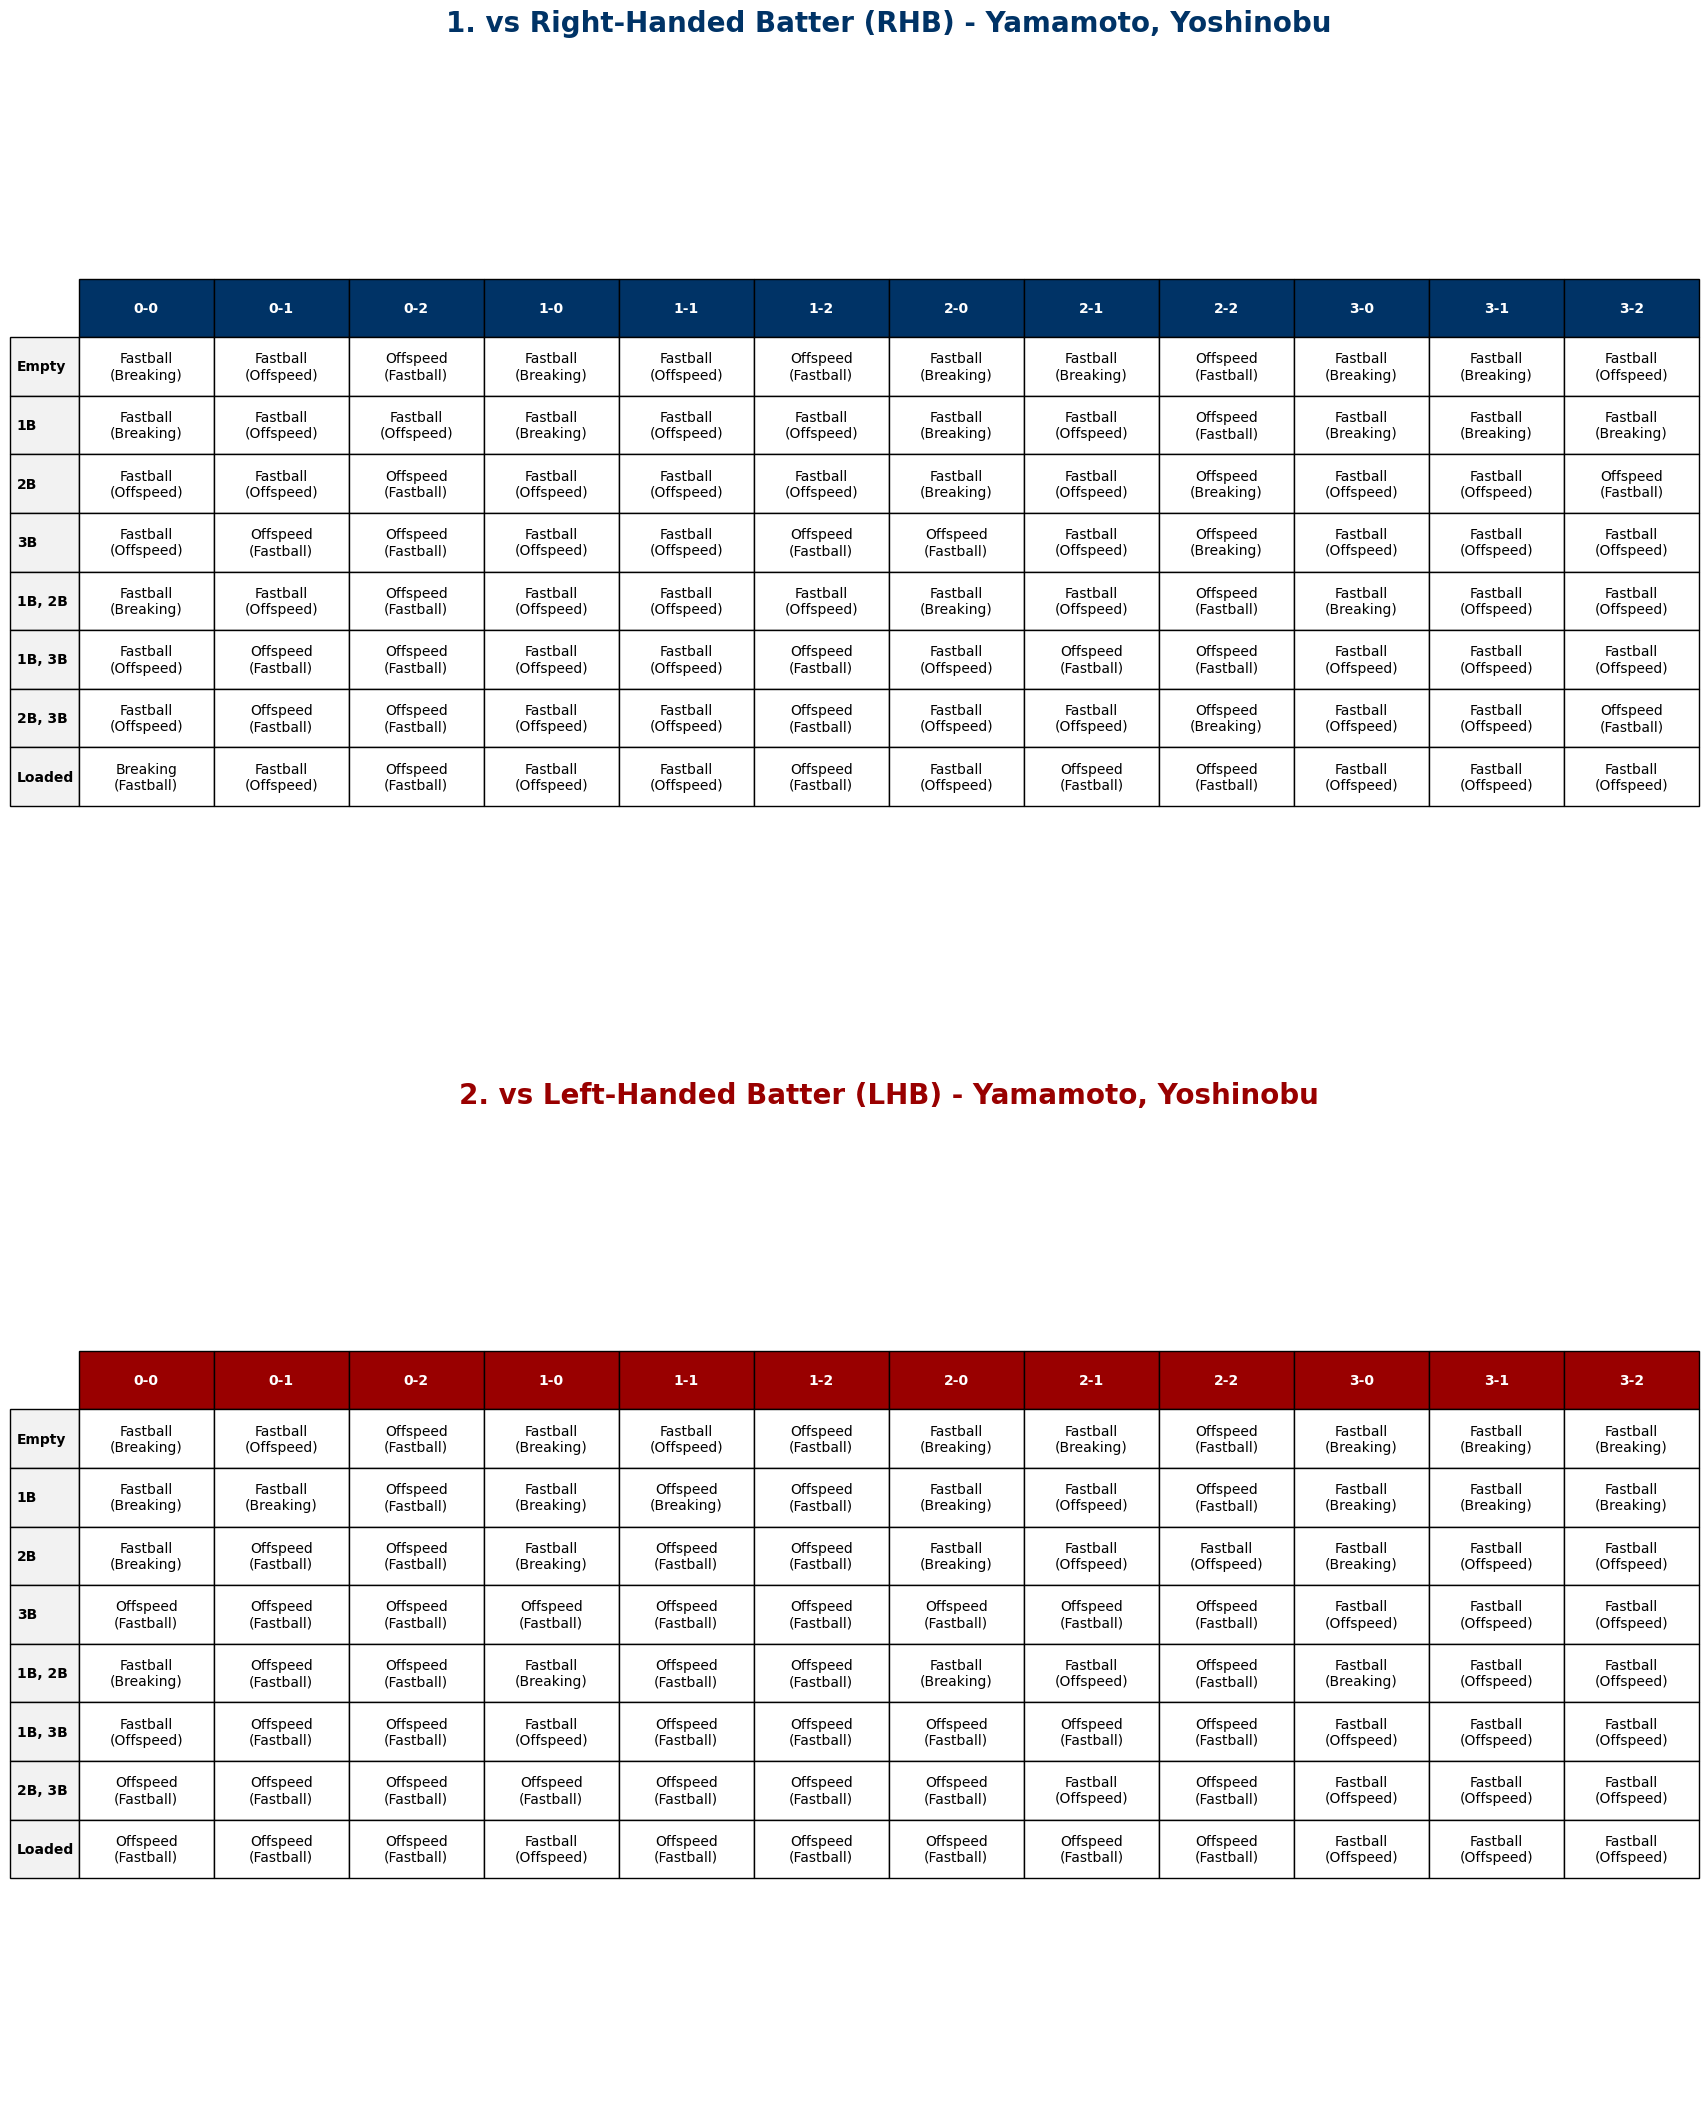

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_strategy_sheet_english(strategy_df, pitcher_name):
    runner_translation = {
        '주자 없음': 'Empty',
        '1루': '1B', '2루': '2B', '3루': '3B',
        '1루,2루': '1B, 2B', '1루,3루': '1B, 3B', '2루,3루': '2B, 3B',
        '만루': 'Loaded'
    }

    runner_order = ['Empty', '1B', '2B', '3B',
                    '1B, 2B', '1B, 3B', '2B, 3B', 'Loaded']

    def get_english_pivot(korean_batter_type):
        sub_df = strategy_df.copy()

        # ★ 타자 문자열 공백 제거
        sub_df['타자'] = sub_df['타자'].astype(str).str.strip()
        sub_df = sub_df[sub_df['타자'] == korean_batter_type]

        if sub_df.empty:
            return pd.DataFrame()

        sub_df['Runners'] = sub_df['주자'].map(runner_translation)

        sub_df['Combined'] = sub_df.apply(
            lambda x: f"{x['1순위 그룹']}\n({x['2순위 그룹']})"
            if x['2순위 그룹'] else x['1순위 그룹'],
            axis=1
        )

        pivot = sub_df.pivot(index='Runners', columns='볼카운트', values='Combined')
        pivot = pivot.reindex(runner_order)

        return pivot

    df_rhb = get_english_pivot("우타자(R)")
    df_lhb = get_english_pivot("좌타자(L)")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 22))

    def draw_table(ax, df, title, header_color):
        ax.axis('tight')
        ax.axis('off')

        if df.empty:
            ax.text(0.5, 0.5, "No Data Available",
                    ha='center', va='center', fontsize=16, color='red')
            ax.set_title(title, fontsize=20, weight='bold', pad=20, color=header_color)
            return

        table = ax.table(
            cellText=df.values,
            rowLabels=df.index,
            colLabels=df.columns,
            cellLoc='center',
            loc='center'
        )

        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.0, 2.8)

        for (row, col), cell in table.get_celld().items():
            if row == 0:
                cell.set_text_props(weight='bold', color='white')
                cell.set_facecolor(header_color)
            elif col == -1:
                cell.set_text_props(weight='bold')
                cell.set_facecolor('#f2f2f2')
            else:
                cell.set_text_props(wrap=True)

        ax.set_title(title, fontsize=20, weight='bold', pad=20, color=header_color)

    draw_table(ax1, df_rhb,
               f"1. vs Right-Handed Batter (RHB) - {pitcher_name}",
               '#003366')

    draw_table(ax2, df_lhb,
               f"2. vs Left-Handed Batter (LHB) - {pitcher_name}",
               '#990000')

    plt.tight_layout(pad=4.0)
    plt.show()

# 함수 실행
plot_strategy_sheet_english(strategy_df, pitcher_name)
